# Data mining project 22/23

## Import libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "10" # to avoid possible memory leak with KMeans

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# kmeans, bisecting kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, AgglomerativeClustering
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import *
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors

## Theory

To understand first each variable, let's review some audio concepts:

The Ryerson Audio-Visual database of Emotional Speech and Song has the following variables: 
A **sample** of an audio is a portion of an audio's wave in certain (small) interval.

The **sample rate** is the number of samples taken per second. This is a frequency and it is measured in kilohertz (kHz). Remember that the more often you take samples of the original audio, the closer to the original you can get.

For understanding the difference between sample and frame take into consideration these formulas:

* Sample rate = number of samples / second
* Frame = 1 sample from each channel (PCM)
* Frame Size = Sample size * Channels
* Frame Rate = frames / second

For PCM, which is a digital representation of an analog signal, the sample rate and the frame rate are the same since a frame consists of a a sample from each channel.

The sample size is the size of an individual sample, also called **Bit Depth** or **Sample Width**, and it indicates how many byte of information a sample contains. (This is one important factor in the quality/resolution of the audio).

An **audio channel** is the path via a signal or data is delivered, i.e, it's where a sound signal is conveyed from the player source to the speaker. For one channel we talk about **mono**, and several channels we refer to **stereo**.  For instance, in stereo sound, there are two audio sources: one speaker on the left, and one on the right. Each of these is represented by one channel.

An **audio frame** is a data record that contains the samples of all the channels available in an audio signal to the same point in time.

The **zero-crossing rate** is the rate at which a signal changes from positive to zero or negative, and from negative to zero or positive. It's a measure of the smoothness of the signal. The zero-crossing rate can be utilized as a basic pitch detection algorithm for monophonic tonal signals and is a key feature to classify percussive sounds.

**Mel-Frequency Cepstral Coefficients** is a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope.

**Spectral Centroid** indicates where the center of mass of the spectrum is located, and it is a good predictor of the 'brightness' of a sound, which depends on distribution of total power between high and low frequencies. Also can be seen as the amplitude-weighted mean of several frequency components.

**stft chromagram**: applying the Fourier transform, which is used to convert a time-dependent signal to a frequency-dependent signal, to local sections of an audio signal, one obtains the short-time Fourier transform (STFT). The Chroma feature or chromagram of an audio represents the intensity of the twelve distinctive pitch classes that are used to study music.

* 'Modality': media file types (audio-only).
* 'Actor' and 'Sex': corresponding identifier of the actor (01 to 24) and its sex (M of F).
* 'statement': phrase repeated by the actors ("Kids are talking by the door", "Dogs are sitting by the door").
* 'repetition': number of repetitions (1st repetition, 2nd repetition).
* 'vocal chanel': type of channel (speech or song).
* 'Emotion': the emotion of the speaker (neutral, calm, happy, sad, angry, fearful, disgust, surprised).
* 'Emotional intensity': level of emotion of each expression (normal, strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* sample_width: number of bytes of storage needed to save the sample (1 means 8-bit, 2 means 16-bit).
* frame_rate: frequency of samples used (in Hertz).
* frame_width: Number of bytes for each frame. One frame contains a sample for each channel.
* length_ms: audio file length in milliseconds.
* frame_count: number of frames from the sample.
* intensity: loudness in dBFS, which is dB relative to the maximum possible loudness.
* zero_crossings_sum: sum of the zero-crossing rate.
* 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the original audio signal.
* mfcc_ 'mean', 'std', 'min', 'max': statistics of the Mel-Frequency Cepstral Coefficients.
* sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the spectral centroid.
* stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the stft chromagram.

Measures to understand the shape of the data:
**Skewness** (skew) measures the symmetry of the distribution

**Kurtosis** (kur) measures the heaviness of the distribution tails, i.e., provides an indication of the presence of outliers.

### Data semantics

## Classification of the variables
* **Nominal/Categorical:** actor, sex, modality, statement, repetition, vocal channel, emotion.
* **Ordinal:**  emotional intensity.
* **Numeric:**   /
* **Ratio-Scaled:** lenght_ms, zero_crossings_sum, frame_rate, frame_width, sample_width, stft_mean, stft_std, stft_min, stft_max, stft_kur, stft_skew, sc_mean, sc_std, sc_min, sc_max, sc_kur, sc_skew, mfcc_mean, mfcc_std, mfcc_min, mfcc_max, 'std', 'min', 'max', 'kur', 'skew'.

The classification of variables depends on the real data?
**The data contained in the dataset are enough.**

What does characteristics of variables mean? It's just about the classification and the domain?
**Charateristics mean std, means, medians, if it's continous or categorical, etc.**

For emotion, is it nominal or ordinal? What about partial ordered sets?
**Emotion is nominal and partial order sets we take like they are not ordered.**

## Data understanding and preparation

In [3]:
df_ini = pd.read_csv("ravdess_features.csv") # read csv file (dataset)

In [4]:
df = df_ini.copy()
df

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,...,0.000000,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,...,0.000000,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,...,0.000000,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,calm,strong,Kids are talking by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247
2448,audio-only,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633
2449,audio-only,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M,1,2,...,0.000000,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821
2450,audio-only,speech,surprised,normal,Kids are talking by the door,1st,NaN,M,1,2,...,0.001565,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966


In [7]:
df.describe().round(2) # some descriptive statistics

,actor,channels,sample_width,frame_rate,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
count,1326.00,2452.00,2452.0,2452.0,2452.0,2452.00,2452.00,1636.00,2452.00,2452.00,...,2452.00,2452.0,2452.00,2452.00,2452.0,2452.00,2452.00,2452.00,2452.00,2452.00
mean,12.58,1.00,2.0,48000.0,2.0,4092.15,193587.19,-37.63,12885.31,-28.77,...,0.00,1.0,-1.25,0.11,0.0,0.02,-0.16,0.18,11.20,-0.05
std,6.92,0.05,0.0,0.0,0.1,598.32,36825.37,8.45,3665.32,4.46,...,0.00,0.0,0.21,0.33,0.0,0.02,0.18,0.20,6.61,0.45
min,1.00,1.00,2.0,48000.0,2.0,2936.00,-1.00,-63.86,4721.00,-43.81,...,0.00,1.0,-1.67,-0.99,-0.0,0.00,-1.00,0.00,1.76,-2.36
25%,7.00,1.00,2.0,48000.0,2.0,3604.00,172972.00,-43.54,10362.50,-31.83,...,0.00,1.0,-1.39,-0.09,-0.0,0.01,-0.20,0.06,6.52,-0.34
50%,13.00,1.00,2.0,48000.0,2.0,4004.00,190591.00,-37.07,12383.50,-28.68,...,0.00,1.0,-1.29,0.13,-0.0,0.01,-0.10,0.11,9.83,0.00
75%,19.00,1.00,2.0,48000.0,2.0,4538.00,217817.00,-31.59,14966.00,-25.55,...,0.00,1.0,-1.15,0.34,0.0,0.03,-0.05,0.22,14.09,0.26
max,24.00,2.00,2.0,48000.0,4.0,6373.00,305906.00,-16.35,30153.00,-15.49,...,0.04,1.0,0.79,1.47,0.0,0.15,-0.01,1.00,59.09,1.80


In [8]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
modality,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,...,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only
vocal_channel,speech,speech,NaN,NaN,song,speech,speech,speech,speech,song,...,song,speech,speech,speech,NaN,speech,speech,song,speech,NaN
emotion,fearful,angry,happy,surprised,happy,fearful,angry,neutral,calm,sad,...,sad,calm,neutral,surprised,sad,calm,calm,sad,surprised,neutral
emotional_intensity,normal,normal,strong,normal,strong,normal,normal,normal,normal,strong,...,strong,normal,normal,strong,normal,strong,normal,strong,normal,normal
statement,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,...,Kids are talking by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door
repetition,2nd,1st,2nd,1st,2nd,2nd,1st,2nd,1st,2nd,...,2nd,1st,2nd,1st,2nd,1st,1st,2nd,1st,2nd
actor,2.0,16.0,16.0,14.0,2.0,NaN,2.0,NaN,12.0,12.0,...,NaN,NaN,NaN,NaN,23.0,23.0,23.0,23.0,NaN,23.0
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
channels,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [9]:
df["stft_mean"].describe()

count    2452.000000
mean        0.475846
std         0.082551
min         0.214089
25%         0.415260
50%         0.475740
75%         0.530571
max         0.724077
Name: stft_mean, dtype: float64

In [10]:
nunique = df.nunique()
nunique

modality                  1
vocal_channel             2
emotion                   8
emotional_intensity       2
statement                 2
repetition                2
actor                    24
sex                       2
channels                  2
sample_width              1
frame_rate                1
frame_width               2
length_ms                95
frame_count             158
intensity               989
zero_crossings_sum     2176
mfcc_mean              2451
mfcc_std               2449
mfcc_min               2451
mfcc_max               2449
sc_mean                2451
sc_std                 2451
sc_min                 1431
sc_max                 2423
sc_kur                 2451
sc_skew                2451
stft_mean              2451
stft_std               2451
stft_min               1431
stft_max                  1
stft_kur               2451
stft_skew              2451
mean                   2450
std                    2451
min                    2148
max                 

In [11]:
to_delete = []
for key, value in nunique.items():
    if(value == 1):
        print("To delete: ", key)
        to_delete.append(key)
    if(value > 1 and value < 100):
        print("To evaluate: ", key)

To delete:  modality
To evaluate:  vocal_channel
To evaluate:  emotion
To evaluate:  emotional_intensity
To evaluate:  statement
To evaluate:  repetition
To evaluate:  actor
To evaluate:  sex
To evaluate:  channels
To delete:  sample_width
To delete:  frame_rate
To evaluate:  frame_width
To evaluate:  length_ms
To delete:  stft_max


In [12]:
df = df.drop(columns=to_delete)

In [ ]:
df = df.drop("mean")

In [15]:
def get_emotion_positivity(x):
    if(x == 'fearful' or x == 'angry' or x =='sad' or x == 'disgust'):
        return -1;
    if(x == 'happy' or x == 'surprised'): # is calm positive?
        return 1;
    return 0;

df["emotion_positivity"] = df["emotion"].map(get_emotion_positivity)
df["emotion_positivity"]

0      -1
1      -1
2       1
3       1
4       1
       ..
2447    0
2448    0
2449   -1
2450    1
2451    0
Name: emotion_positivity, Length: 2452, dtype: int64

In [17]:
df["length"] = df["length_ms"] / 1000
df = df.drop(columns=["length_ms"])

In [19]:
df["zero_crossings_rate"] = df["zero_crossings_sum"] / df["length"]
df["zero_crossings_rate"]

0       4547.765587
1       3561.987705
2       4008.349390
3       3194.116030
4       3437.102634
           ...     
2447    2143.539631
2448    2148.885159
2449    1863.905325
2450    2599.946481
2451    2456.867344
Name: zero_crossings_rate, Length: 2452, dtype: float64

In [20]:
df = df.drop(columns=["zero_crossings_sum"])

In [1]:
df['statement'] = df['statement'].replace(['Dogs are sitting by the door'], '0')
df['statement'] = df['statement'].replace(['Kids are talking by the door'], '1')

NameError: name 'df' is not defined

### Checking synctactic accuracy

In [ ]:
df["modality"].value_counts()

In [ ]:
df["vocal_channel"].value_counts()

In [ ]:
df["emotion"].value_counts()

In [ ]:
df["emotional_intensity"].value_counts()

In [ ]:
df["statement"].value_counts()

In [ ]:
df["repetition"].value_counts()

In [ ]:
df["sex"].value_counts()

In [ ]:
df["actor"].value_counts()

In this way we check if there are some strange values or entries that are not in the domain. At the same time, we check the mode of each variable. As result, we find that all nominal/categorical and ordinal variables values seems to be synctactically accurate.

### Checking semantic accuracy

In [24]:
actors = df[["actor", "sex"]]
actors.value_counts()

actor  sex
22.0   F      65
12.0   F      63
14.0   F      62
20.0   F      61
8.0    F      61
13.0   M      60
19.0   M      60
16.0   F      58
2.0    F      58
24.0   F      58
5.0    M      58
10.0   F      56
11.0   M      55
6.0    F      55
17.0   M      55
21.0   M      55
4.0    F      52
9.0    M      51
7.0    M      51
3.0    M      51
23.0   M      51
1.0    M      51
15.0   M      44
18.0   F      35
dtype: int64

In [25]:
emo_EI = df[["emotion", "emotional_intensity"]]
emo_EI.value_counts()

emotion    emotional_intensity
angry      normal                 188
           strong                 188
calm       normal                 188
           strong                 188
fearful    normal                 188
           strong                 188
happy      normal                 188
           strong                 188
neutral    normal                 188
sad        normal                 188
           strong                 188
disgust    normal                  96
           strong                  96
surprised  normal                  96
           strong                  96
dtype: int64

We check if there are some semantic inconsistencies in the couples actor-sex (for instance duplicate actors with different sex) and emotion-emotional_intensity (there must be no _strong_ emotional_intensity values with _neutral_ emotion values). There seems to be no semantic inconsistencies.

### NaN values

In [26]:
df.isna().sum()

vocal_channel           196
emotion                   0
emotional_intensity       0
statement                 0
repetition                0
actor                  1126
sex                       0
channels                  0
frame_width               0
frame_count               0
intensity               816
mfcc_mean                 0
mfcc_std                  0
mfcc_min                  0
mfcc_max                  0
sc_mean                   0
sc_std                    0
sc_min                    0
sc_max                    0
sc_kur                    0
sc_skew                   0
stft_mean                 0
stft_std                  0
stft_min                  0
stft_kur                  0
stft_skew                 0
mean                      0
std                       0
min                       0
max                       0
kur                       0
skew                      0
emotion_positivity        0
length                    0
zero_crossings_rate       0
dtype: int64

In this way we check if there are NaN values (missing values) and how many they are.

Suming the 0 values we obtain that sc_min and stft_min can be correlated because have the same quantity of 0 values = 1021.

### Charts and relations

In [31]:
vocal_channel = pd.crosstab(df["sex"], df["vocal_channel"])
vocal_channel

vocal_channel,song,speech
sex,,
F,434,671
M,487,664


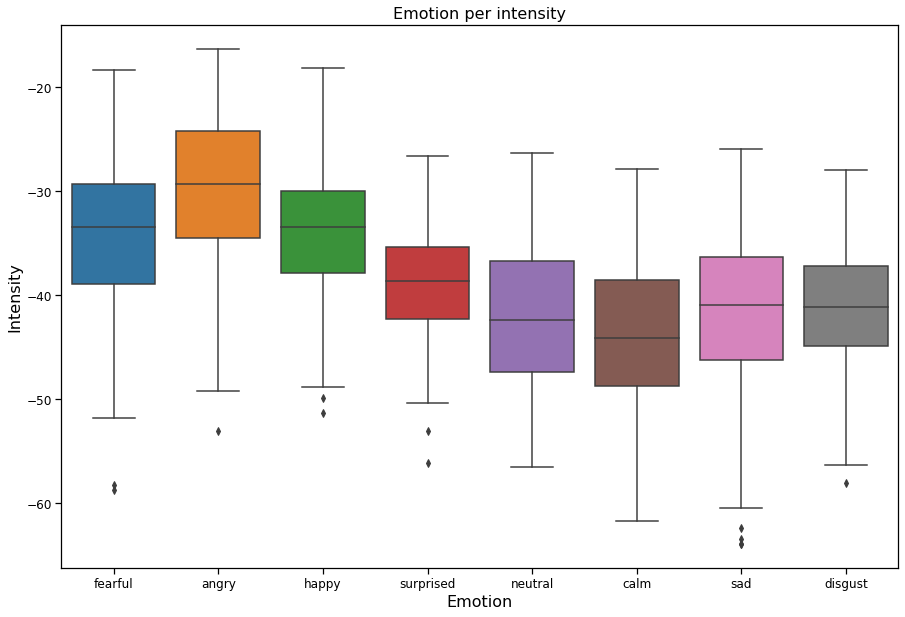

In [33]:
sns.boxplot(x = "emotion", y = "intensity", data = df)
plt.title("Emotion per intensity")
plt.xlabel("Emotion")
plt.ylabel("Intensity")
#plt.savefig("boxplot_emotionIntensity.png")
plt.show()

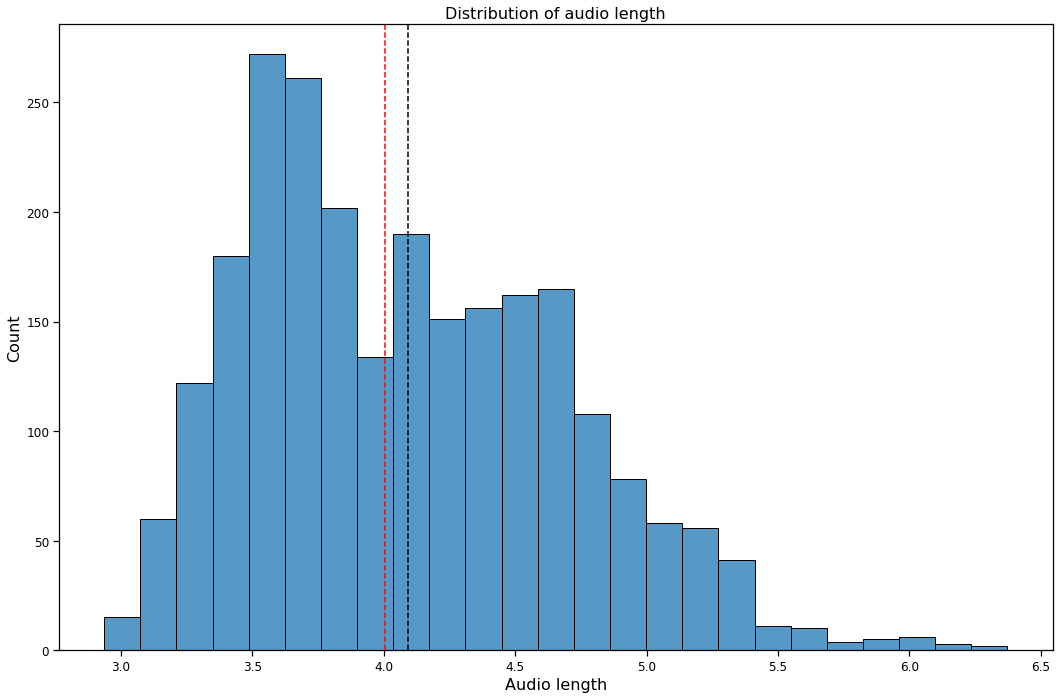

In [36]:
sns.histplot(df["length"])
plt.title("Distribution of audio length")
plt.xlabel("Audio length")
plt.ylabel("Count")
plt.axvline(df['length'].mean(), color = "k", linestyle = "--") # mean (black dotted line)
plt.axvline(df['length'].median(), color = "r", linestyle = "--") # median (red dotted line)
plt.tight_layout()
#plt.savefig("histplot_lenghtms.png")
plt.show()

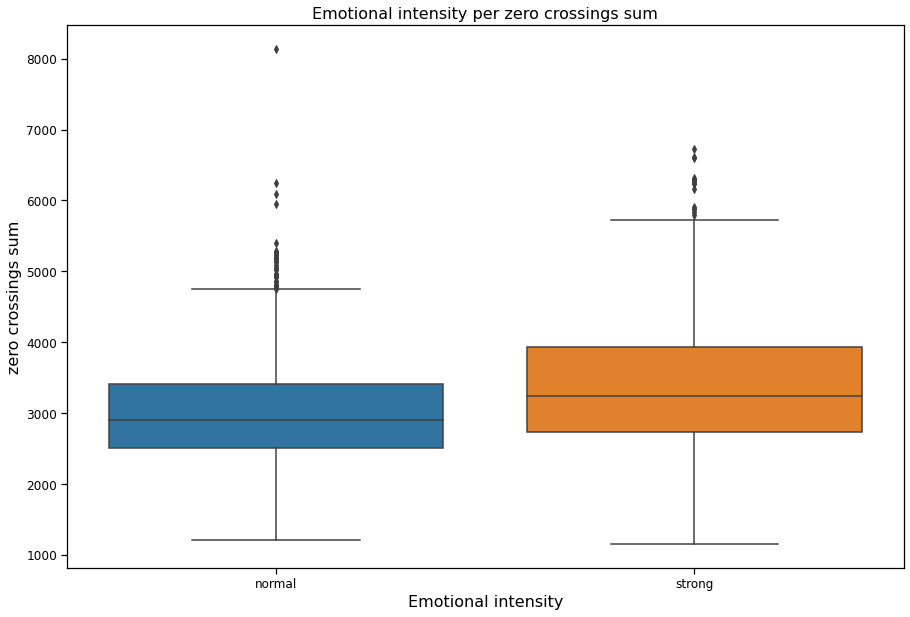

In [46]:
sns.boxplot(x = "emotional_intensity", y = "zero_crossings_rate", data = df)
plt.title("Emotional intensity per zero crossings sum")
plt.xlabel("Emotional intensity")
plt.ylabel("zero crossings sum")
#plt.savefig("boxplot_EI-ZCS.png")
plt.show()

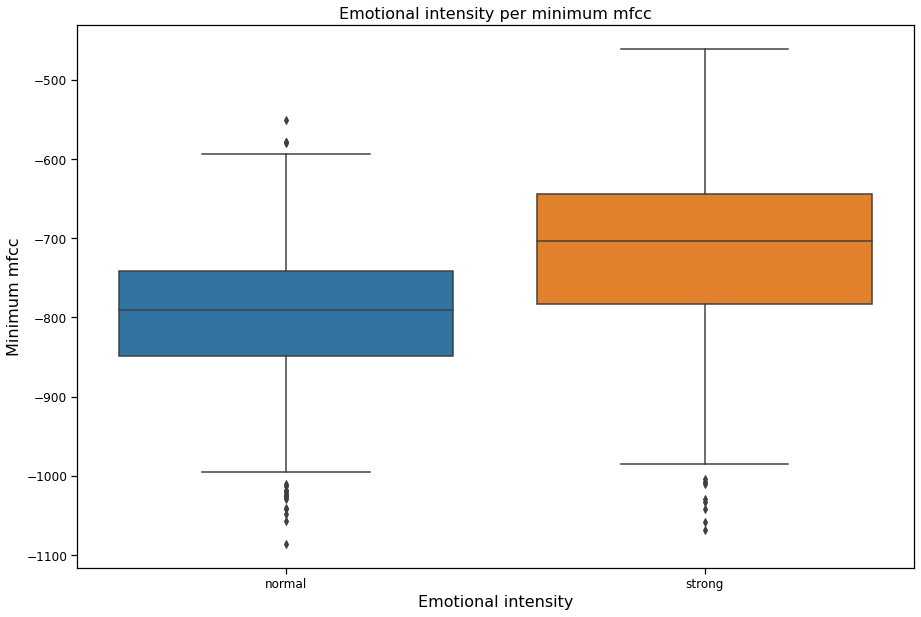

In [52]:
sns.boxplot(x = "emotional_intensity", y = "mfcc_min", data = df)
plt.title("Emotional intensity per minimum mfcc")
plt.xlabel("Emotional intensity")
plt.ylabel("Minimum mfcc")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

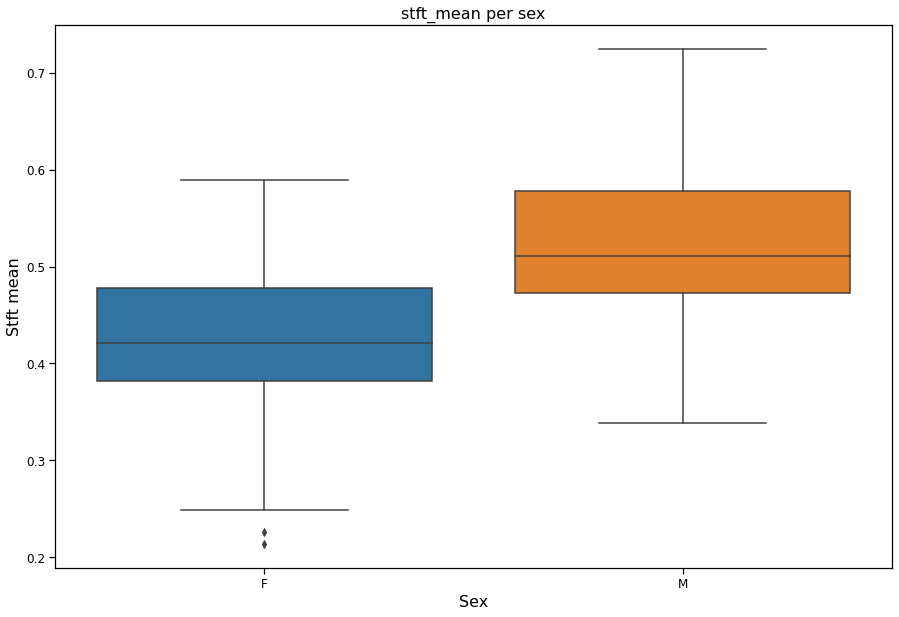

In [53]:
sns.boxplot(x = "sex", y = "stft_mean", data = df)
plt.title("stft_mean per sex")
plt.xlabel("Sex")
plt.ylabel("Stft mean")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_33776/2196359511.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


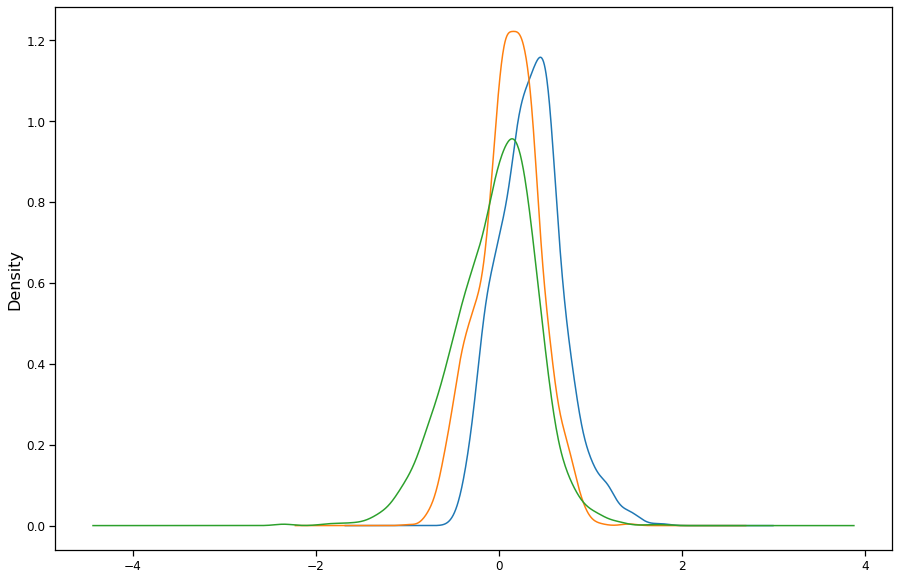

In [67]:
skew_features = df[["sc_skew","stft_skew","skew"]]
fig, ax = plt.subplots(1,1)
for s in skew_features.columns:
    df[s].plot(kind='density')
fig.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_33776/2833179634.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


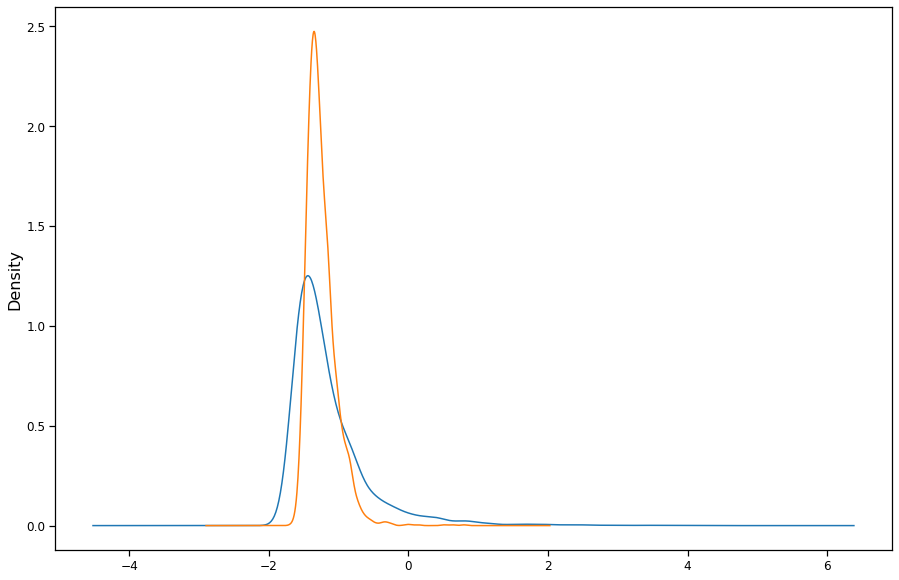

In [68]:
kur_features = df[["sc_kur","stft_kur"]]
fig, ax = plt.subplots(1,1)
for s in kur_features.columns:
    df[s].plot(kind='density')
fig.show()

## Outliers - Single attribute

**Definition of outliers computation**

In [70]:
def outliers(variable) :
    Q1 = df[variable].quantile(0.25, interpolation = 'linear')
    Q3 = df[variable].quantile(0.75, interpolation = 'linear')
    IQR = Q3 - Q1
    Lowerfence = Q1 - 1.5*IQR
    Upperfence = Q3 + 1.5*IQR
    OUTLIERS = df.loc[(df[variable] < Lowerfence)  |  (df[variable] > Upperfence) ]
    NORMAL_Spec = df.loc[(df[variable] > Lowerfence)  & (df[variable] < Upperfence) ]
    return OUTLIERS[variable].round(2)

In [72]:
print(outliers("length"))

61      6.37
435     6.11
739     6.01
959     6.11
1292    6.17
1438    6.34
1617    6.07
1777    6.04
1791    5.97
1922    6.01
2158    6.04
Name: length, dtype: float64


In [75]:
print(outliers("frame_width"))

287     4
778     4
1045    4
1336    4
1348    4
1809    4
Name: frame_width, dtype: int64


In [77]:
print(outliers("stft_mean"))

748     0.72
1438    0.23
2253    0.21
Name: stft_mean, dtype: float64


In [79]:
print(outliers("stft_std"))

149     0.26
171     0.26
209     0.26
419     0.26
433     0.26
444     0.26
446     0.26
448     0.24
455     0.26
475     0.26
508     0.27
741     0.26
748     0.21
749     0.27
1007    0.27
1060    0.27
1085    0.25
1123    0.25
1125    0.27
1233    0.27
1234    0.25
1253    0.27
1291    0.24
1489    0.27
1803    0.26
1843    0.25
1849    0.27
1855    0.26
2102    0.27
2119    0.26
2120    0.26
2141    0.24
2159    0.26
Name: stft_std, dtype: float64


In [81]:
print(outliers("stft_min")) # if the output is too long to visualize look at the "Length" property

60      0.01
69      0.01
75      0.01
84      0.01
85      0.01
        ... 
2438    0.01
2439    0.02
2440    0.01
2441    0.01
2444    0.02
Name: stft_min, Length: 336, dtype: float64


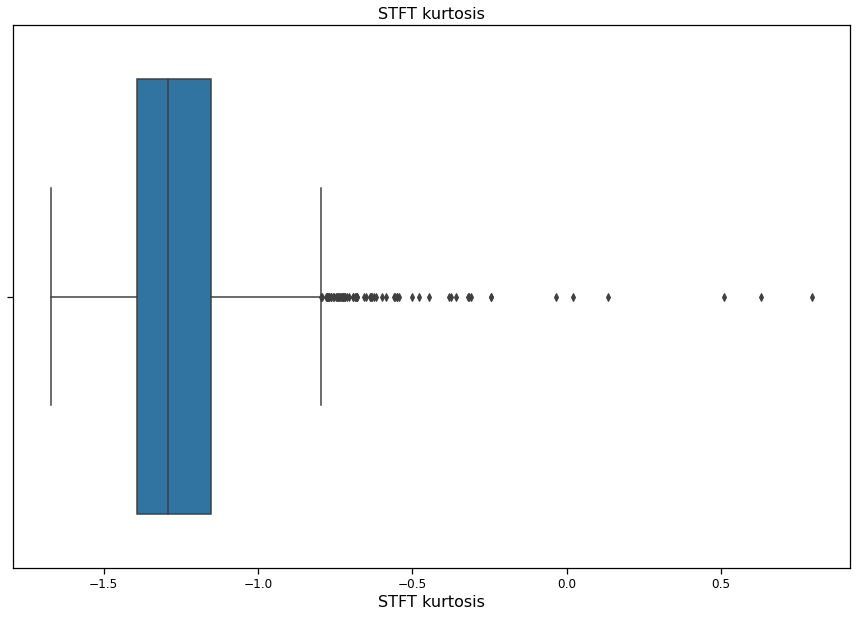

In [82]:
sns.boxplot(x = "stft_kur", data = df)
plt.title("STFT kurtosis")
plt.xlabel("STFT kurtosis")
#plt.savefig("boxplot_stftKur.png")
plt.show()

In [83]:
print(outliers("stft_kur"))

61     -0.36
119    -0.76
131    -0.64
149    -0.75
150    -0.76
        ... 
2345   -0.38
2372   -0.74
2374   -0.50
2424   -0.72
2438   -0.73
Name: stft_kur, Length: 69, dtype: float64


In [85]:
print(outliers("stft_skew"))

61      1.05
131    -0.80
171    -0.74
1028   -0.76
1085   -0.76
1425    1.00
1438    1.38
1818   -0.76
1829   -0.81
2024    1.12
2068   -0.77
2141   -0.76
2159   -0.99
2253    1.47
Name: stft_skew, dtype: float64


In [87]:
print(outliers("sc_mean"))

1545    2684.60
1687    7655.34
1791    2360.88
2253    2454.04
2277    2604.36
Name: sc_mean, dtype: float64


In [89]:
print(outliers("sc_std"))

76      1885.50
113     1696.86
129     1832.49
154     1544.54
381     1852.68
439     1852.94
497     1684.75
521     1633.91
524     1568.52
525     1491.34
591     1649.18
680     1681.33
734     1881.94
803     1855.52
827     1795.03
834     1670.17
1077    1881.54
1187    1580.81
1425    1506.39
1480    1496.55
1545    1820.60
1799    1791.24
1851    1599.72
1868    1796.64
1897    1884.65
1992    1587.00
2137    1858.15
2395    1900.73
2396    1624.71
2403    1732.09
Name: sc_std, dtype: float64


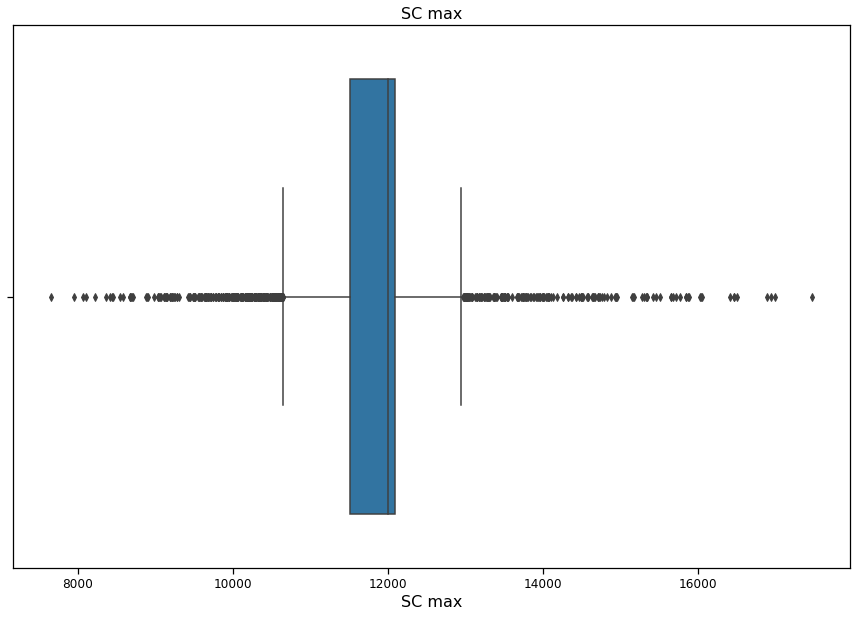

In [90]:
sns.boxplot(x = "sc_max", data = df)
plt.title("SC max")
plt.xlabel("SC max")
#plt.savefig("boxplot_scMax.png")
plt.show()

In [91]:
print(outliers("sc_max"))

0       13541.96
29      13315.14
35       9816.39
38      10321.26
40      13131.70
          ...   
2405     8698.88
2406     9443.33
2421     8907.59
2423    10439.88
2441    10365.49
Name: sc_max, Length: 439, dtype: float64


In [93]:
print(outliers("sc_kur"))

36      0.41
37      0.45
42      0.36
58     -0.17
59      1.69
        ... 
2404    1.90
2420   -0.13
2436    0.81
2437    0.85
2442   -0.08
Name: sc_kur, Length: 152, dtype: float64


In [95]:
print(outliers("sc_skew"))

37      1.30
42      1.25
59      1.36
61      1.35
83      1.42
129     1.45
435     1.39
486     1.37
733     1.26
734     1.55
784     1.31
804     1.46
809     1.40
834     1.47
952     1.47
954     1.28
971     1.75
1004    1.27
1462    1.27
1480    1.67
1527    1.35
1580    1.39
1595    1.44
1777    1.43
1791    1.55
1868    1.54
1891    1.35
1928    1.46
2024    1.25
2106    1.28
2158    1.29
2253    1.83
2399    1.27
2403    1.29
2404    1.54
Name: sc_skew, dtype: float64


In [97]:
print(outliers("mfcc_mean"))

525    -16.09
651    -41.30
823    -15.55
1380   -43.81
1392   -42.12
1479   -15.99
1480   -15.49
1563   -15.64
2025   -41.93
2300   -41.54
2319   -41.58
2404   -15.58
Name: mfcc_mean, dtype: float64


In [99]:
print(outliers("mfcc_std"))

1380    195.94
Name: mfcc_std, dtype: float64


In [101]:
print(outliers("mfcc_min"))

209    -1085.48
241    -1042.14
269     -461.49
270     -482.96
349    -1057.60
651    -1041.26
748    -1032.56
1123   -1040.88
1291   -1026.95
1380   -1068.12
1829   -1047.57
2025   -1057.28
2141   -1029.37
2300   -1028.60
Name: mfcc_min, dtype: float64


In [103]:
print(outliers("mfcc_max"))

1139    280.17
Name: mfcc_max, dtype: float64


In [106]:
print(outliers("std"))

17      0.08
36      0.06
37      0.06
101     0.09
113     0.07
        ... 
2403    0.06
2405    0.09
2417    0.07
2423    0.12
2429    0.07
Name: std, Length: 172, dtype: float64


In [108]:
print(outliers("min"))

17     -0.64
23     -0.52
33     -0.52
36     -0.52
37     -0.49
        ... 
2405   -0.68
2414   -0.47
2417   -0.76
2423   -0.98
2429   -0.67
Name: min, Length: 207, dtype: float64


In [110]:
print(outliers("max"))

17      0.64
23      0.49
33      0.59
36      0.54
101     1.00
        ... 
2405    0.83
2417    0.94
2423    1.00
2429    0.71
2430    0.50
Name: max, Length: 207, dtype: float64


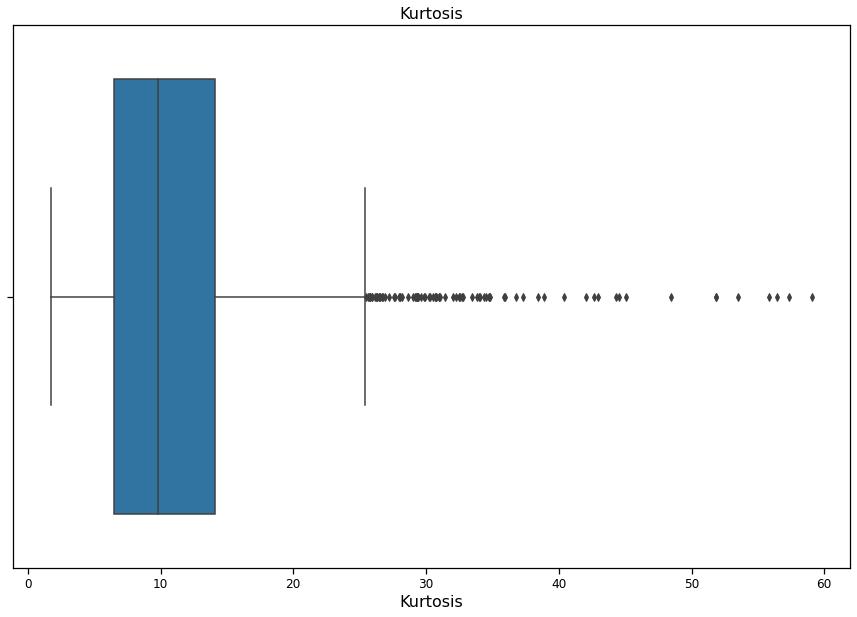

In [111]:
sns.boxplot(x = "kur", data = df)
plt.title("Kurtosis")
plt.xlabel("Kurtosis")
#plt.savefig("boxplot_kur.png")
plt.show()

In [112]:
print(outliers("kur"))

40      28.03
89      32.53
90      32.79
91      33.47
101     28.02
        ...  
2195    59.09
2289    29.90
2346    25.48
2375    29.34
2439    30.33
Name: kur, Length: 85, dtype: float64


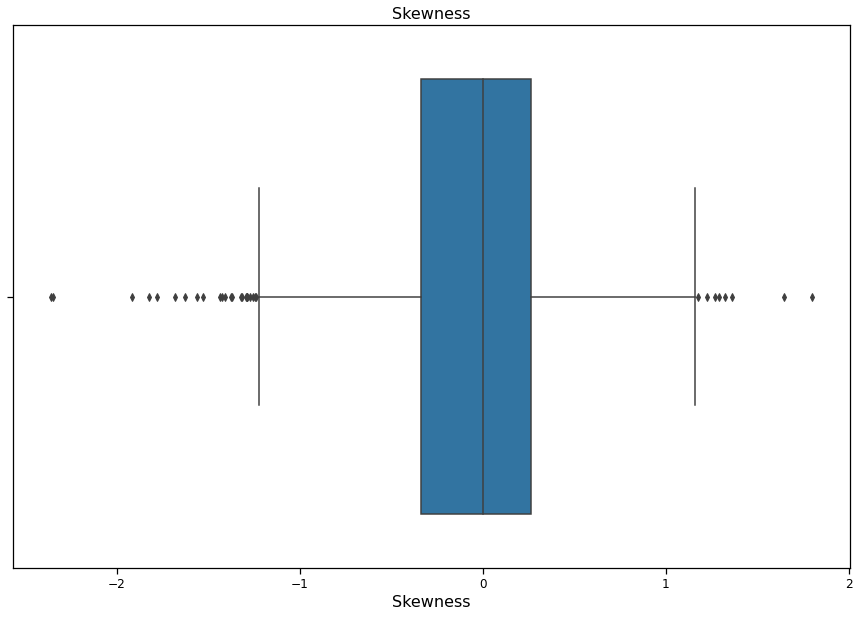

In [113]:
sns.boxplot(x = "skew", data = df)
plt.title("Skewness")
plt.xlabel("Skewness")
#plt.savefig("boxplot_skew.png")
plt.show()

In [114]:
print(outliers("skew"))

145    -1.29
153    -1.24
168    -1.42
216     1.18
433    -1.27
475     1.80
476    -1.25
508     1.22
577    -1.24
741    -1.32
758    -1.37
832    -1.32
927    -1.29
975     1.32
988     1.29
1057   -1.63
1064   -1.78
1066   -1.82
1110   -1.92
1246    1.27
1288   -1.38
1464    1.36
1522    1.64
1639   -1.29
1803   -2.35
1804   -1.53
1818   -1.41
1835   -1.56
2067   -1.43
2114   -2.36
2327   -1.29
2398   -1.68
Name: skew, dtype: float64


**Maybe at this point we can calculate outliers for categorical/nominal attributes, which are values that occurs with a frequency extremely lower than the frequency of all other values.**

# Transformation

In [115]:
df[["emotional_intensity","intensity"]]

,emotional_intensity,intensity
0,normal,-36.793432
1,normal,NaN
2,strong,-32.290737
3,normal,-49.019839
4,strong,-31.214503
...,...,...
2447,strong,NaN
2448,normal,-43.342901
2449,strong,NaN
2450,normal,-45.751265


In [116]:
df.sort_values("intensity")["intensity"].dropna()

209    -63.864613
1123   -63.864613
2025   -63.460545
2102   -62.350199
2159   -61.681723
          ...    
2345   -18.328814
1747   -18.183522
443    -17.070853
1070   -16.496218
801    -16.353953
Name: intensity, Length: 1636, dtype: float64

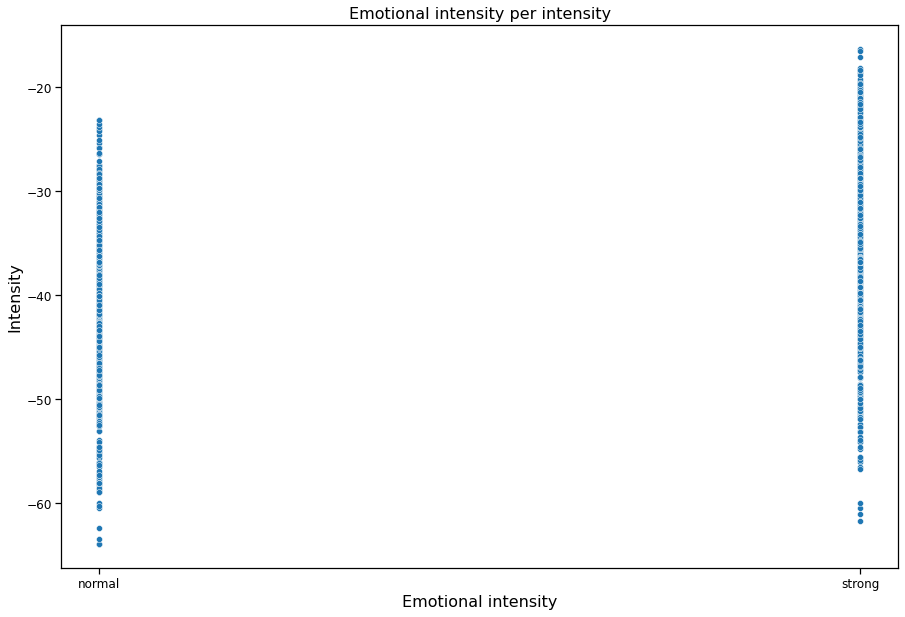

In [117]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

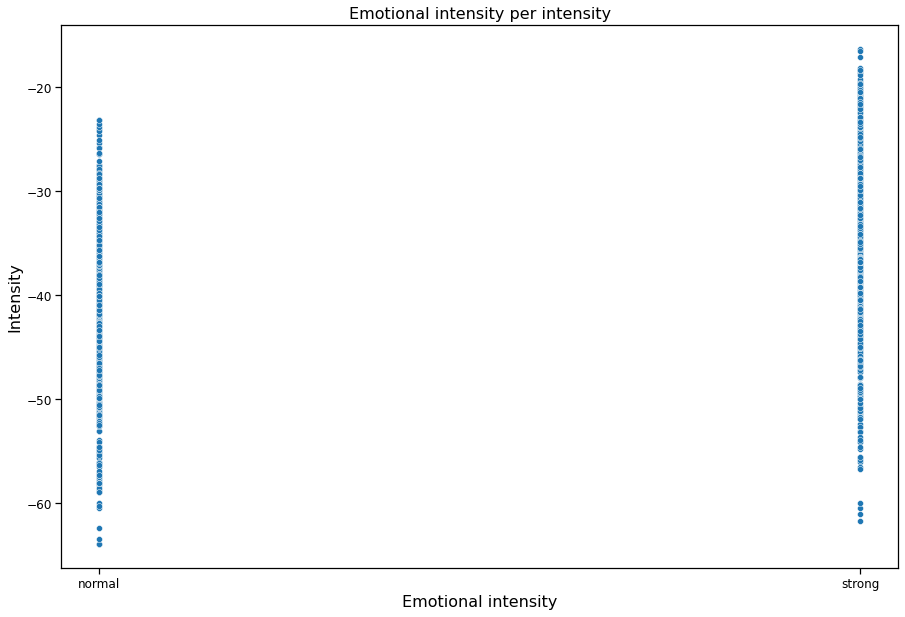

In [118]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

In [119]:
def densityPlot(vars):
    skew_features = df[vars]
    fig, ax = plt.subplots(1,1)
    for s in skew_features.columns:
        df[s].plot(kind = 'density')
    fig.show()

In [120]:
df['zero_crossings_rate_normalized'] = zscore(df['zero_crossings_rate'])
df = df.drop(columns=["zero_crossings_rate"])

C:\Users\claud\AppData\Local\Temp/ipykernel_33776/1420422831.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


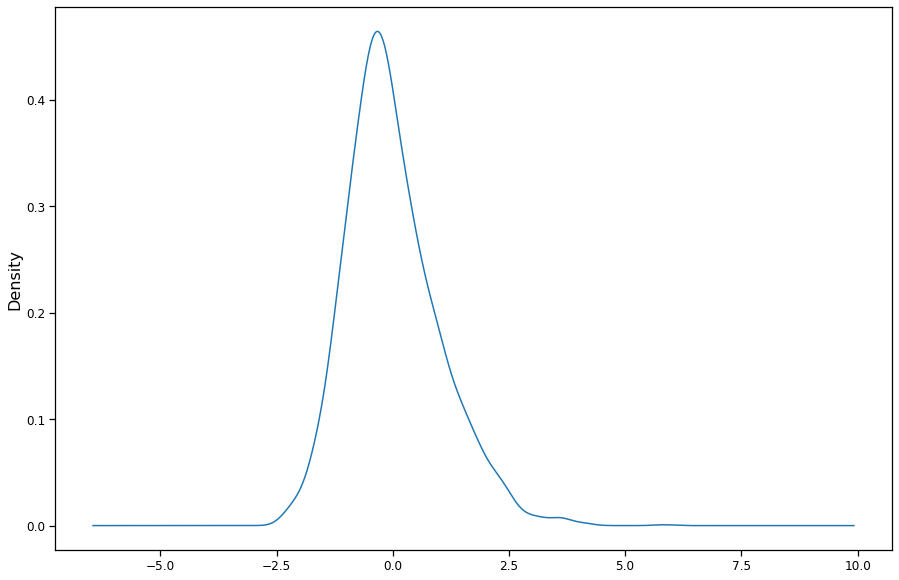

In [121]:
densityPlot(["zero_crossings_rate_normalized"])

In [122]:
df['sc_mean_normalized'] = zscore(df['sc_mean'])
df = df.drop(columns=["sc_mean"])

C:\Users\claud\AppData\Local\Temp/ipykernel_33776/1420422831.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


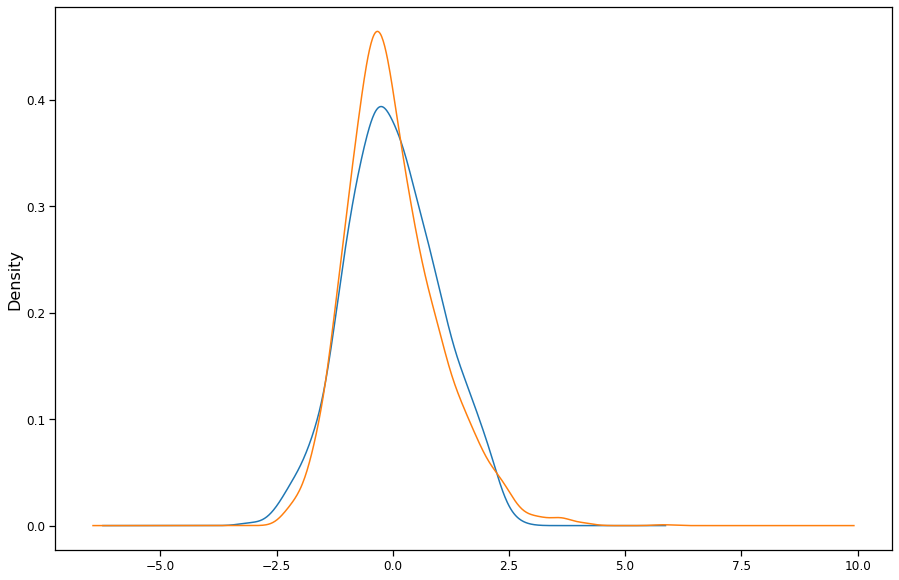

In [123]:
densityPlot(["sc_mean_normalized", "zero_crossings_rate_normalized"])

## Pairwise correlations and eventual elimination of variables

We drop _frame_rate_ column because there is just _length_ that measures the length of audio and of course _frame_rate_ is proportional to _length_.

In [124]:
df_num = df.copy() # copy of all numerical and ratio-scaled attributes

In [125]:
df_num = df_num.drop(columns = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width"])
df_num.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
intensity,-3.679343e+01,NaN,-32.290737,-4.901984e+01,-3.121450e+01,-3.631224e+01,NaN,-4.909504e+01,-4.590684e+01,NaN,...,-29.512788,-47.141749,NaN,NaN,-36.811776,NaN,-4.334290e+01,NaN,-45.751265,-4.001804e+01
mfcc_mean,-3.348595e+01,-2.950211e+01,-30.532463,-3.605956e+01,-3.140600e+01,-3.050089e+01,-3.017717e+01,-3.604858e+01,-3.389936e+01,-29.462296,...,-22.787794,-28.682810,-25.771196,-25.815453,-24.805220,-3.022558e+01,-3.116033e+01,-26.135280,-28.242815,-2.901924e+01
mfcc_std,1.346549e+02,1.304856e+02,126.577110,1.597252e+02,1.221258e+02,1.325817e+02,1.395075e+02,1.676521e+02,1.591976e+02,116.833786,...,113.349300,154.492430,157.241900,147.116780,138.314590,1.588455e+02,1.574997e+02,138.133210,159.943400,1.491890e+02
mfcc_min,-7.552234e+02,-7.139856e+02,-726.060360,-8.429464e+02,-7.007028e+02,-7.191655e+02,-7.671936e+02,-9.104974e+02,-8.792600e+02,-645.926200,...,-659.389100,-859.211730,-821.105700,-798.653700,-782.337340,-8.559242e+02,-8.253741e+02,-768.365360,-868.095760,-7.995101e+02
mfcc_max,1.716909e+02,2.050077e+02,165.456530,1.900361e+02,1.611340e+02,2.136819e+02,2.283271e+02,2.203837e+02,2.076322e+02,167.967530,...,202.859280,197.396960,251.228530,214.569700,219.623290,2.081850e+02,2.207949e+02,235.539380,219.843500,2.195278e+02
sc_std,3.328055e+03,4.040932e+03,3332.131300,4.053663e+03,3.442724e+03,3.833178e+03,4.008804e+03,3.737829e+03,4.014630e+03,3602.202957,...,3149.520778,3663.074145,3300.232336,3055.279038,3194.246906,4.114260e+03,4.191727e+03,4231.511986,3596.031841,3.963725e+03
sc_min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,991.364402,...,979.297084,0.000000,818.317638,511.528673,840.068705,0.000000e+00,0.000000e+00,0.000000,760.822547,0.000000e+00
sc_max,1.354196e+04,1.200029e+04,12007.751173,1.204822e+04,1.202558e+04,1.206320e+04,1.284023e+04,1.200001e+04,1.208151e+04,11999.999998,...,11981.598019,12192.374121,10834.058255,10919.537644,11191.358052,1.221052e+04,1.206456e+04,12207.179884,11981.912464,1.219977e+04
sc_kur,-1.120769e+00,-1.531204e+00,-1.130153,-1.497765e+00,-1.167544e+00,-1.114527e+00,-1.503746e+00,-1.601514e+00,-1.609622e+00,-1.288444,...,-0.083404,-0.959309,-1.540621,-1.178478,-1.478019,-1.588861e+00,-1.614582e+00,-1.337419,-1.465594,-1.501387e+00
sc_skew,2.509402e-01,2.195818e-01,0.436699,9.880228e-02,4.960657e-01,5.551978e-01,9.221132e-02,-1.127366e-01,-7.267137e-02,0.542700,...,1.129704,0.506089,-0.184184,0.421965,0.424980,1.843897e-01,-1.139205e-01,0.619346,0.206481,1.475739e-01


In [126]:
#sns.pairplot(df_num)
#plt.savefig("pairplot_df_num.png")
#plt.show()

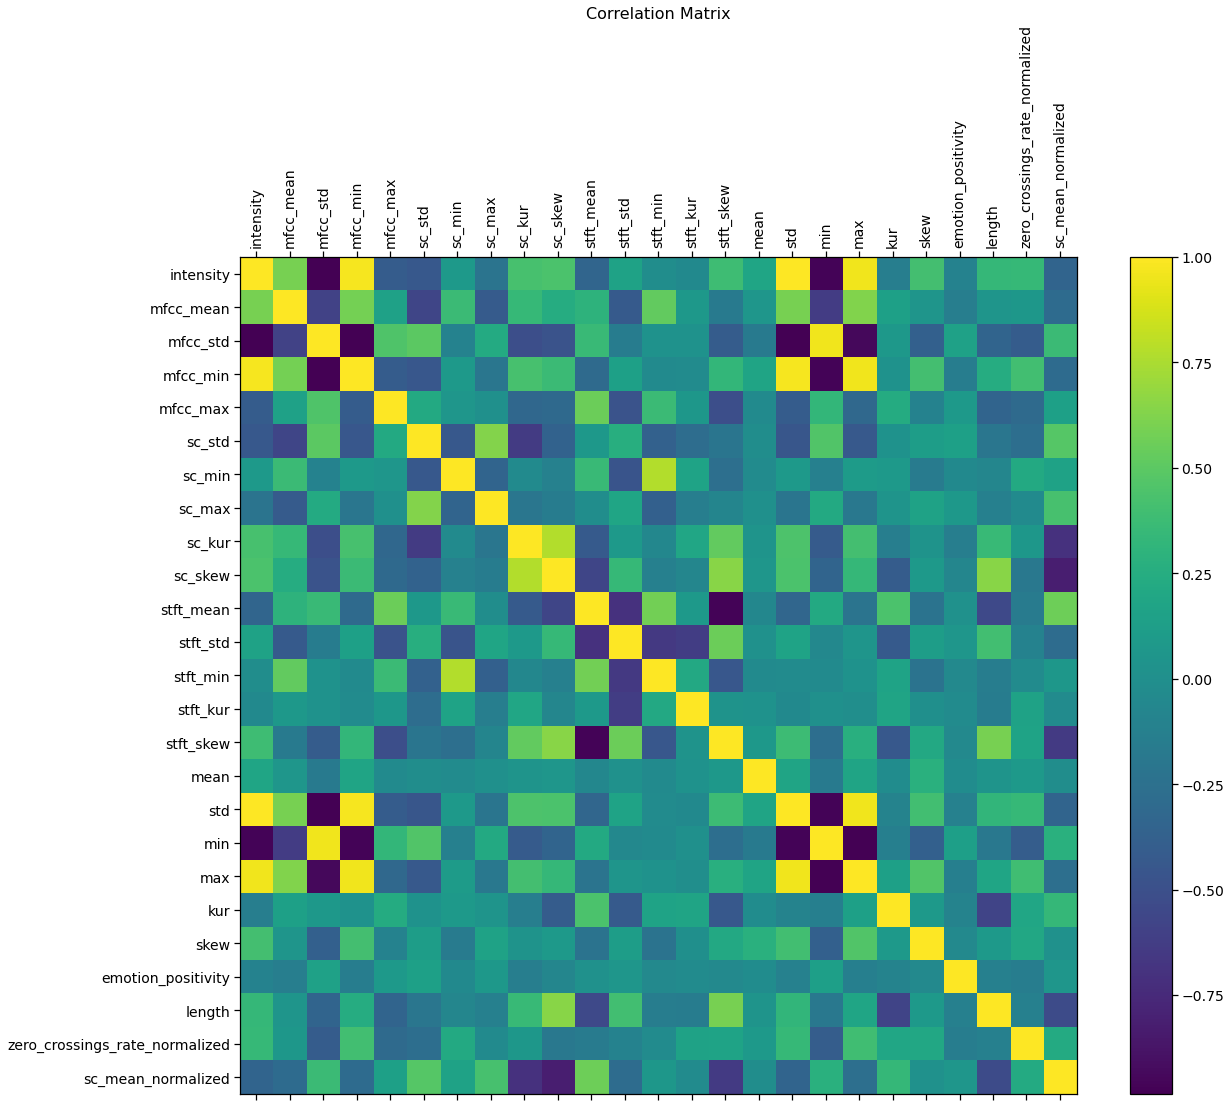

In [127]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_num.corr("spearman"), fignum=f.number)
plt.xticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [128]:
corr = df_num[["intensity", "mfcc_min", "min"]].corr("spearman")
corr.style.background_gradient(cmap='coolwarm')

,intensity,mfcc_min,min
intensity,1.000000,0.972007,-0.961140
mfcc_min,0.972007,1.000000,-0.968147
min,-0.961140,-0.968147,1.000000


In [129]:
eps = 0.90
alg = "spearman"
print("CORRELATION > ",eps,":")
corr = (df_num.corr(alg))
for index, row in corr.iterrows():
    for k, v in row.items():
        if(v > eps and index != k):
            print(index, k, corr[index][k])
    
print("")
print("CORRELATION < -",eps,":")
neg_corr = (df_num.corr(alg))
for index, row in neg_corr.iterrows():
    for k, v in row.items():
        if(v  < -eps and index != k):
            print(index, k, v)

CORRELATION >  0.9 :
intensity mfcc_min 0.9739806185030634
mfcc_min intensity 0.9739806185030634
std max 0.9528208795190594
max std 0.9528208795190594

CORRELATION < - 0.9 :
intensity mfcc_std -0.9787440246139893
mfcc_std intensity -0.9787440246139893
mfcc_std mfcc_min -0.9760982975983237
mfcc_min mfcc_std -0.9760982975983237
stft_mean stft_skew -0.9699787898983478
stft_skew stft_mean -0.9699787898983478
std min -0.9558475650435299
min std -0.9558475650435299
min max -0.9798894359969872
max min -0.9798894359969872


In [ ]:
correlation_drop_cols = ["std", "mfcc_min", "max", "mfcc_std", "stft_skew", "min"]
df_num = df_num.drop(columns=correlation_drop_cols)

In [ ]:
df_norm = pd.DataFrame()
for v in df_num:
    df_norm[v] = zscore(df_num[v].dropna())
df_norm

In [131]:
df_num.describe()

,intensity,mfcc_mean,mfcc_max,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,mean,std,kur,skew,emotion_positivity,length,zero_crossings_rate_normalized,sc_mean_normalized
count,1636.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2.452000e+03,2.452000e+03
mean,-37.625332,-28.769180,199.182514,3365.453393,551.834124,11830.461864,-1.142642,0.348442,0.475846,0.331371,0.002272,-1.247929,1.393649e-08,0.020504,11.203002,-0.048245,-0.306688,4.092151,-4.746973e-16,5.922397e-16
std,8.451982,4.461886,26.002107,580.479034,508.025890,1004.955976,0.572654,0.353005,0.082551,0.023773,0.004830,0.211781,4.267587e-05,0.021024,6.614859,0.454925,0.822315,0.598322,1.000204e+00,1.000204e+00
min,-63.864613,-43.812923,126.250810,1491.341071,0.000000,7657.495158,-1.795576,-0.510390,0.214089,0.210126,0.000000,-1.669603,-9.435575e-04,0.000652,1.757794,-2.356526,-1.000000,2.936000,-2.357317e+00,-3.210512e+00
25%,-43.539869,-31.828597,180.081417,3025.431971,0.000000,11516.034429,-1.496187,0.098549,0.415260,0.317780,0.000000,-1.390612,-1.394488e-06,0.006791,6.519988,-0.336624,-1.000000,3.604000,-6.757194e-01,-6.930420e-01
50%,-37.072745,-28.681109,201.697175,3433.835368,707.319256,12000.292653,-1.308938,0.347621,0.475740,0.334224,0.000190,-1.292105,-9.810701e-08,0.013880,9.828686,0.004256,-1.000000,4.004000,-1.498243e-01,-5.415859e-02
75%,-31.591309,-25.550238,218.185288,3768.503344,977.693852,12091.886054,-0.982944,0.557427,0.530571,0.349272,0.001999,-1.152519,8.363511e-07,0.026154,14.085435,0.262978,0.000000,4.538000,5.626651e-01,6.924041e-01
max,-16.353953,-15.491450,280.173700,4819.783069,2121.417965,17477.540047,3.657953,1.825436,0.724077,0.391928,0.039378,0.794669,1.222810e-03,0.152168,59.085695,1.799676,1.000000,6.373000,5.826633e+00,2.840245e+00


In [132]:
desc = df_num.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

intensity: 11.948559652602661
mfcc_mean: 6.278359000000002
mfcc_max: 38.10387000000003
sc_std: 743.0713734869682
sc_min: 977.6938519007109
sc_max: 575.8516251850451
sc_kur: 0.513242853914685
sc_skew: 0.45887848473075143
stft_mean: 0.115310735
stft_std: 0.03149214
stft_min: 0.0019994863500000003
stft_kur: 0.23809270305753993
mean: 2.230838875e-06
std: 0.019363594499999998
kur: 7.56544712292974
skew: 0.5996017074669128
emotion_positivity: 1.0
length: 0.9340000000000002
zero_crossings_rate_normalized: 1.2383845166095826
sc_mean_normalized: 1.385446152388487


Treshold > 15: "mfcc_max", "sc_std", "sc_min", "sc_max"

In [133]:
'''
df_num["intensity_normalized"] = zscore(df_num["intensity"].dropna())
df_num["mfcc_mean_normalized"] = zscore(df_num["mfcc_mean"])
df_num["mfcc_max_normalized"] = zscore(df_num["mfcc_max"])
df_num["sc_std_normalized"] = zscore(df_num["sc_std"])
df_num["sc_min_normalized"] = zscore(df_num["sc_min"])
df_num["sc_max_normalized"] = zscore(df_num["sc_max"])
df_num["stft_min_normalized"] = zscore(df_num["stft_min"])
df_num["mean_normalized"] = zscore(df_num["mean"])
df_num["std_normalized"] = zscore(df_num["std"])
df_num["kur_normalized"] = zscore(df_num["kur"])
df_num = df_num.drop(columns=["intensity", "mfcc_mean", "sc_std", "mfcc_max", "sc_std", "sc_min", "sc_max", "stft_min", "mean", "std", "kur"])
'''

In [134]:
desc = df_norm.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

sc_kur: 0.513242853914685
sc_skew: 0.45887848473075143
stft_mean: 0.115310735
stft_std: 0.03149214
stft_kur: 0.23809270305753993
skew: 0.5996017074669128
emotion_positivity: 1.0
length: 0.9340000000000002
zero_crossings_rate_normalized: 1.2383845166095826
sc_mean_normalized: 1.385446152388487
intensity_normalized: 1.4141314054531322
mfcc_mean_normalized: 1.4073958144370113
mfcc_max_normalized: 1.4657136147189087
sc_std_normalized: 1.2803613910025171
sc_min_normalized: 1.9248886677577186
sc_max_normalized: 0.5731286741893198
stft_min_normalized: 0.41407111589780127
mean_normalized: 0.052284674357053265
std_normalized: 0.9212157954765399
kur_normalized: 1.1439381927818992


In [135]:
df_num.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
sc_kur,-1.120769,-1.531204,-1.130153,-1.497765,-1.167544,-1.114527,-1.503746,-1.601514,-1.609622,-1.288444,...,-0.083404,-0.959309,-1.540621,-1.178478,-1.478019,-1.588861,-1.614582,-1.337419,-1.465594,-1.501387
sc_skew,0.250940,0.219582,0.436699,0.098802,0.496066,0.555198,0.092211,-0.112737,-0.072671,0.542700,...,1.129704,0.506089,-0.184184,0.421965,0.424980,0.184390,-0.113920,0.619346,0.206481,0.147574
stft_mean,0.415250,0.417488,0.379758,0.407277,0.415974,0.349669,0.476312,0.487306,0.535030,0.506043,...,0.434530,0.493316,0.647158,0.575689,0.466211,0.573838,0.591010,0.467994,0.578854,0.554946
stft_std,0.335533,0.352380,0.352270,0.360552,0.350655,0.345256,0.346839,0.328248,0.328253,0.367643,...,0.337443,0.323536,0.280072,0.315758,0.340911,0.304496,0.306333,0.347843,0.308684,0.320787
stft_kur,-1.215025,-1.384174,-1.242947,-1.445318,-1.366742,-1.098179,-1.425898,-1.307958,-1.262960,-1.544716,...,-1.323040,-1.183935,-0.894654,-1.256183,-1.426536,-1.075888,-1.026071,-1.473789,-1.277117,-1.257666
skew,0.273153,0.292157,0.302659,-0.081014,0.414872,0.028186,0.011188,0.211353,-0.964433,0.475098,...,-0.002707,-0.520648,-0.021519,0.226566,0.227780,0.759247,1.073633,-0.005821,-0.110966,1.032081
emotion_positivity,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,...,-1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
length,3.737000,3.904000,4.671000,3.637000,4.404000,3.570000,3.770000,3.437000,3.770000,4.371000,...,4.872000,3.837000,3.504000,3.237000,5.005000,4.605000,4.171000,5.239000,3.737000,3.837000
zero_crossings_rate_normalized,1.620277,0.462944,0.986986,0.031052,0.316326,0.274410,0.715285,0.088720,1.043515,-0.220751,...,-1.057849,-0.543516,-1.255952,-0.897927,-0.439393,-1.202356,-1.196080,-1.530655,-0.666520,-0.834500
sc_mean_normalized,0.711365,0.031450,-0.387835,0.235821,-0.027530,-1.050260,0.626448,1.045826,1.347705,0.361831,...,-1.430158,-0.583105,0.496742,-0.599125,-0.915396,0.818903,1.637291,-0.589647,0.405295,1.042934


## Analysis by centroid-based methods

### KMeans, Bisecting KMeans

**SSE, KMeans and Bisecting KMeans plot function**

In [188]:
def drawSSEKMeansPlots (df, column_indices, xlabel, ylabel, variables, nclusters) :
    # normalization (zscore)
    X = variables.values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scal = scaler.transform(X)
    
    # SSE plot
    sse_list = []
    for k in range(2, 18): # 15 centroids
        kmeans = KMeans(n_clusters = k, n_init = 10, max_iter = 100)
        kmeans.fit(X_scal)
        sse_list.append(kmeans.inertia_)
    sns.lineplot(x = range(2, 18), y = sse_list, marker = 'o')
    plt.title("SSE " + xlabel + ' vs ' + ylabel, fontsize = 15)
    plt.xlabel('k (# of initial centroids)')
    plt.ylabel('SSE')
    plt.show()
    
    # KMeans plot
    kmeans = KMeans(n_clusters = nclusters, n_init = 10, max_iter = 100)
    kmeans.fit(X_scal)
    centers = kmeans.cluster_centers_
    centers = scaler.inverse_transform(centers)
    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue = kmeans.labels_, style = kmeans.labels_, palette = "bright")
    plt.title("KMeans " + xlabel + " vs " + ylabel, fontsize = 15)
    plt.legend()
    plt.scatter(centers[:, 0], centers[:, 1], c = 'black', marker = '*', s = 200)
    plt.show()
    
    # Bisecting KMeans plot
    bkmeans = BisectingKMeans(n_clusters = nclusters)
    bkmeans.fit(X_scal)
    centersbis = bkmeans.cluster_centers_
    centersbis = scaler.inverse_transform(centersbis)
    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue = bkmeans.labels_, palette = "bright", style = bkmeans.labels_)
    plt.title("Bisecting KMeans " + xlabel + " vs " + ylabel, fontsize = 15)
    plt.scatter(centersbis[:, 0], centersbis[:, 1], c = 'black', marker = '*', s = 200)
    plt.show()

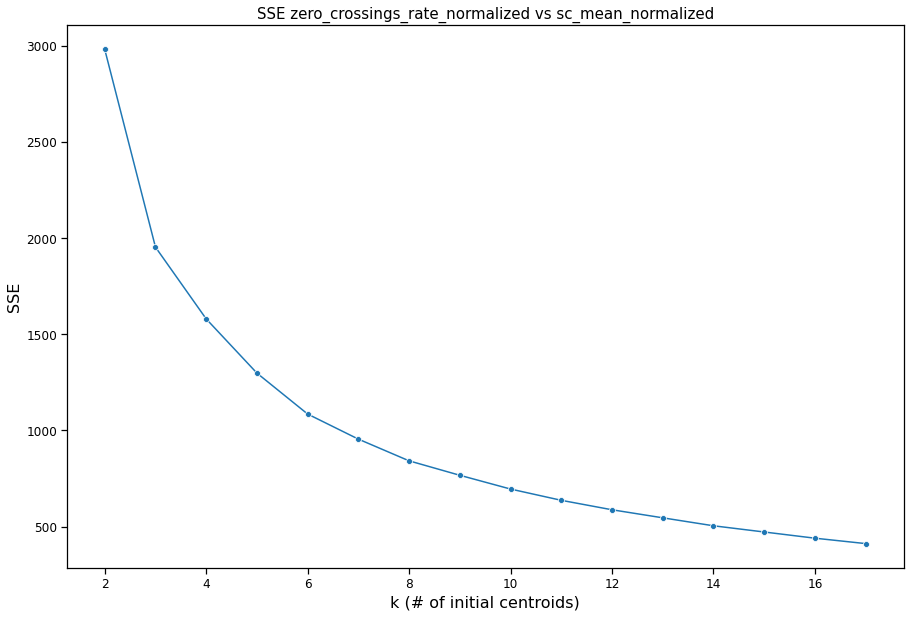

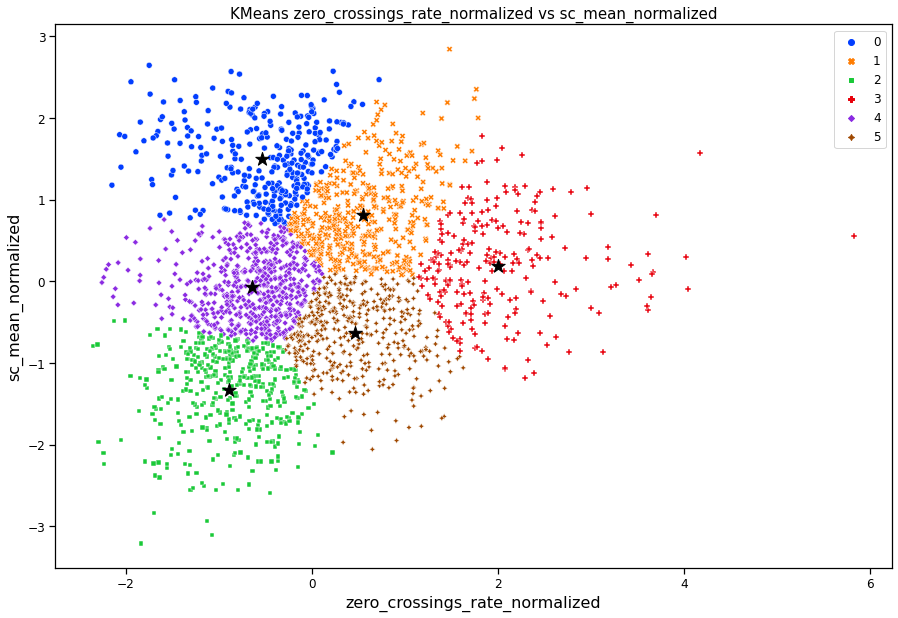

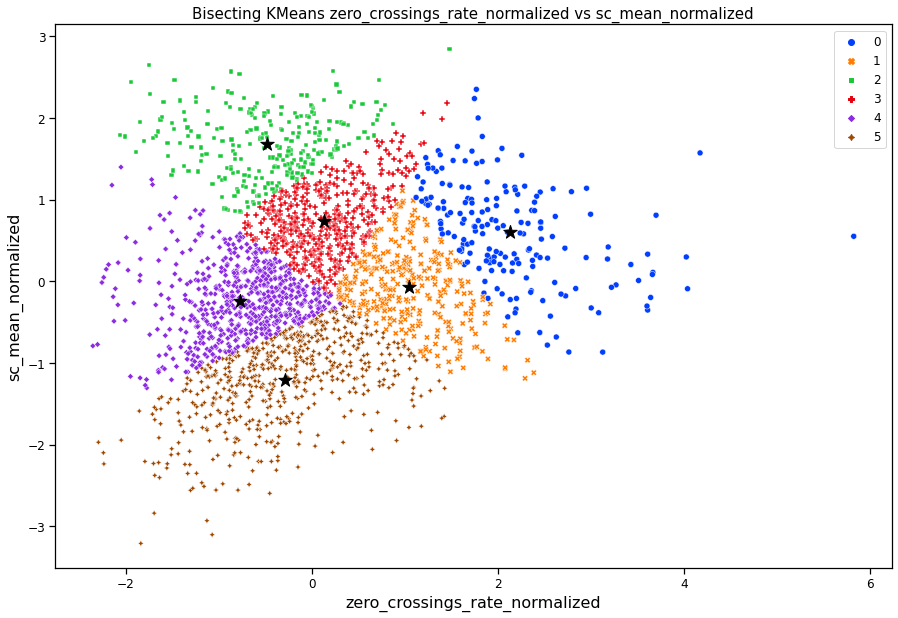

In [190]:
xvar = "zero_crossings_rate_normalized" # first attribute
yvar = "sc_mean_normalized" # second attribute
indices = [8, 9] # column indices of attributes
nclust = 6 # # of clusters of KMeans and Bisecting KMeans
drawSSEKMeansPlots(df_num, indices, xvar, yvar, df_num[[xvar, yvar]], nclust)

According to the SSE plot, in this case six clusters seems to be a good compromise between SSE and number of clusters, because from that point onwards the variation tends to be more linear. The shape of this scatterplot is, more or less, globular. We can see how Bisecting KMeans produces hierarchical clustering compared to KMeans.

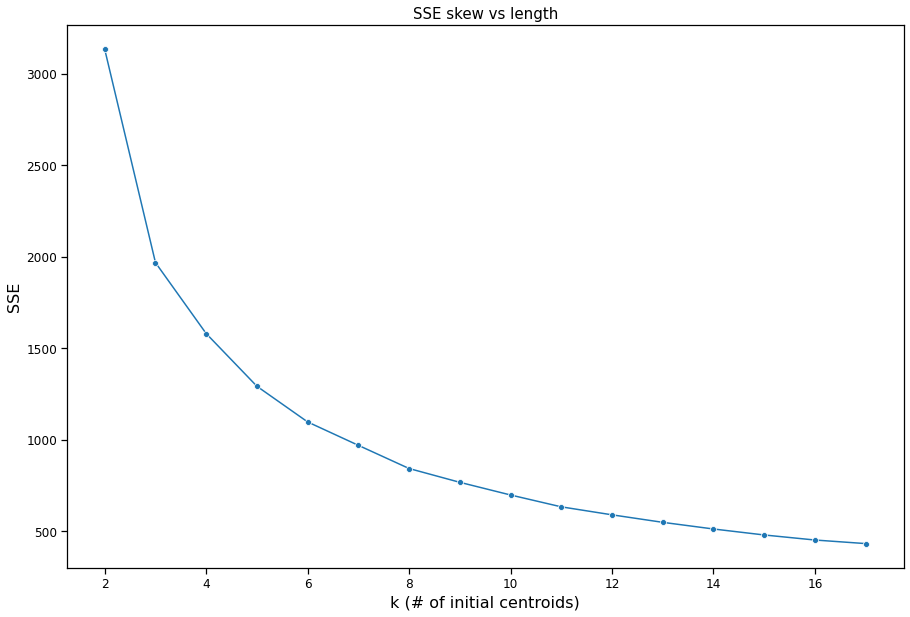

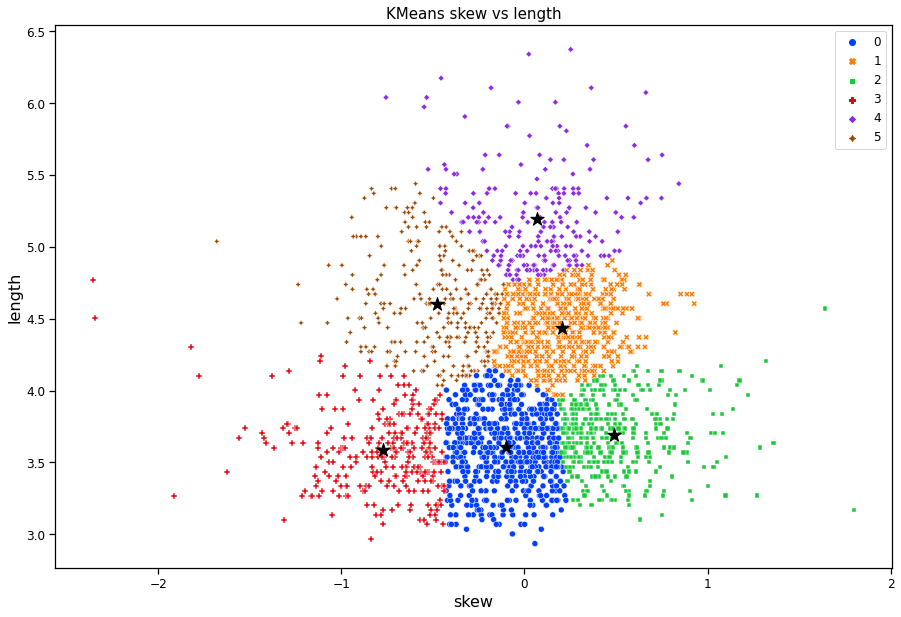

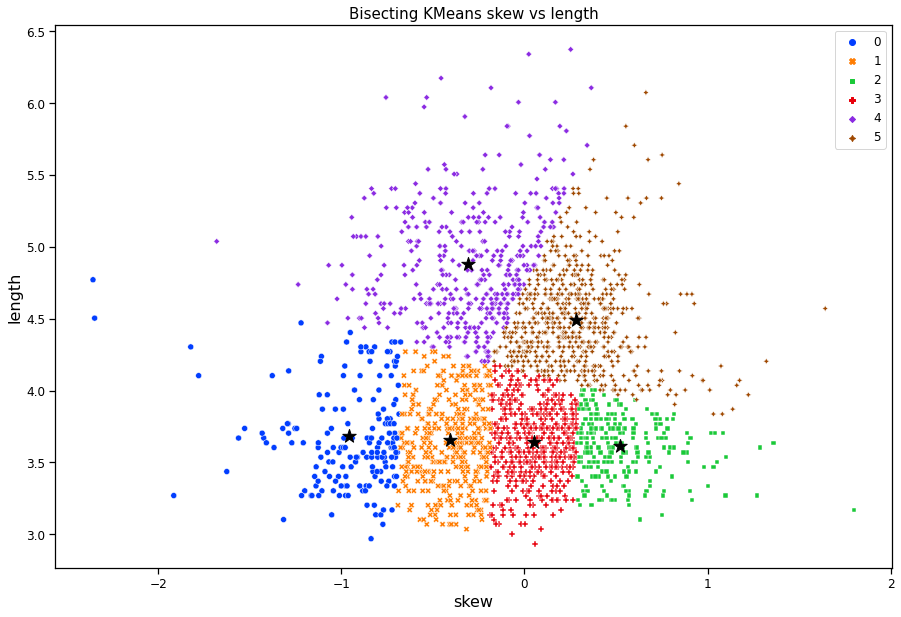

In [184]:
xvar = "skew"
yvar = "length"
indices = [5, 7]
nclust = 6
drawSSEKMeansPlots(df_num, indices, xvar, yvar, df_num[[xvar, yvar]], nclust)

Also in this case we can see that Bisecting KMeans produces a different clustering, more compact than the KMeans's one which tends to have a Christmas tree shape instead. Also in this case, according to the SSE plot, six clusters seems to be a good choice and the shape of the scatterplot tends to be globular in its boundaries.

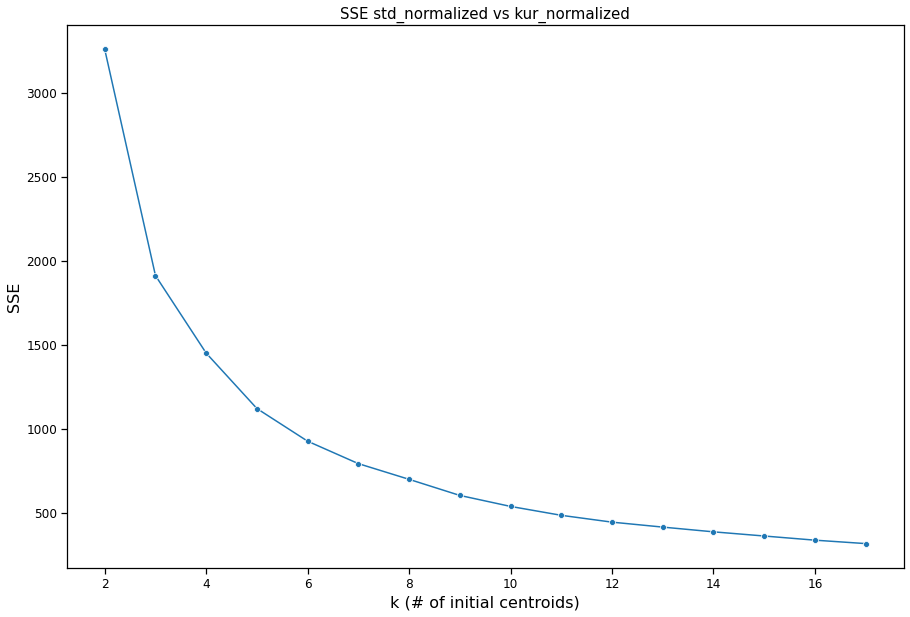

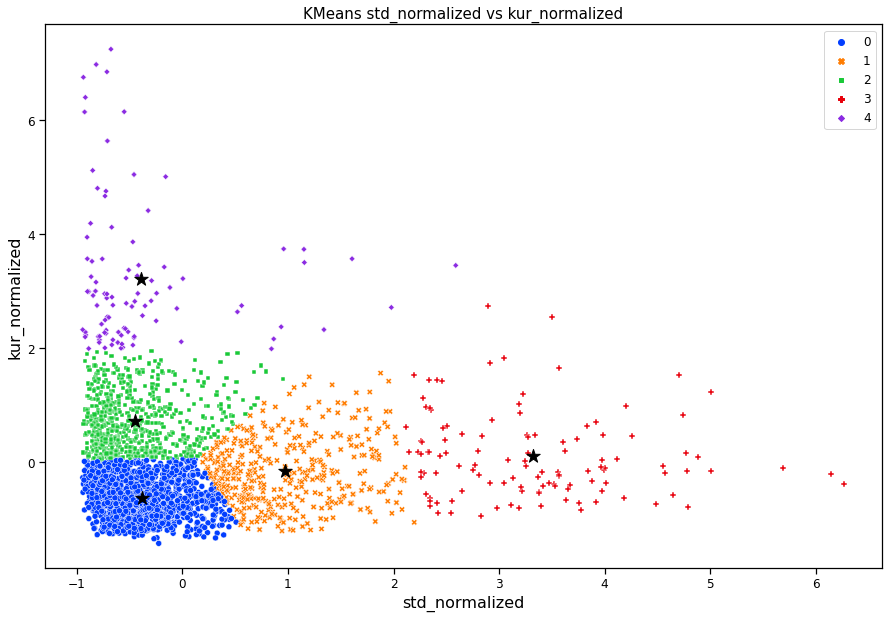

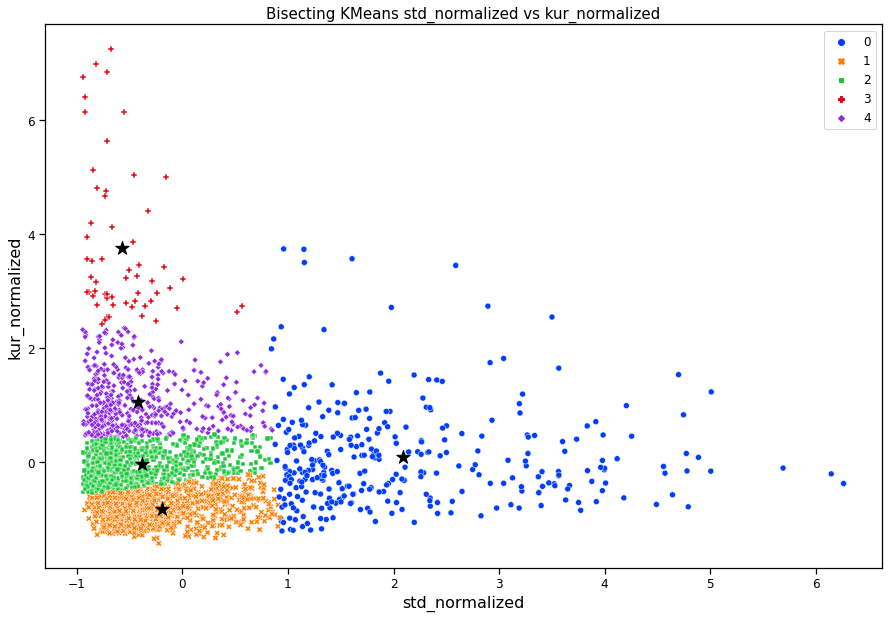

In [185]:
xvar = "std_normalized"
yvar = "kur_normalized"
indices = [18, 19]
nclust = 5
drawSSEKMeansPlots(df_num, indices, xvar, yvar, df_num[[xvar, yvar]], nclust)

In this case the shape of the scatterplot is non-globular but according to the SSE plot, it seems that five cluster are enough to reach a good compromise. Again, we can notice the difference in clustering between KMeans and Bisecting KMeans.

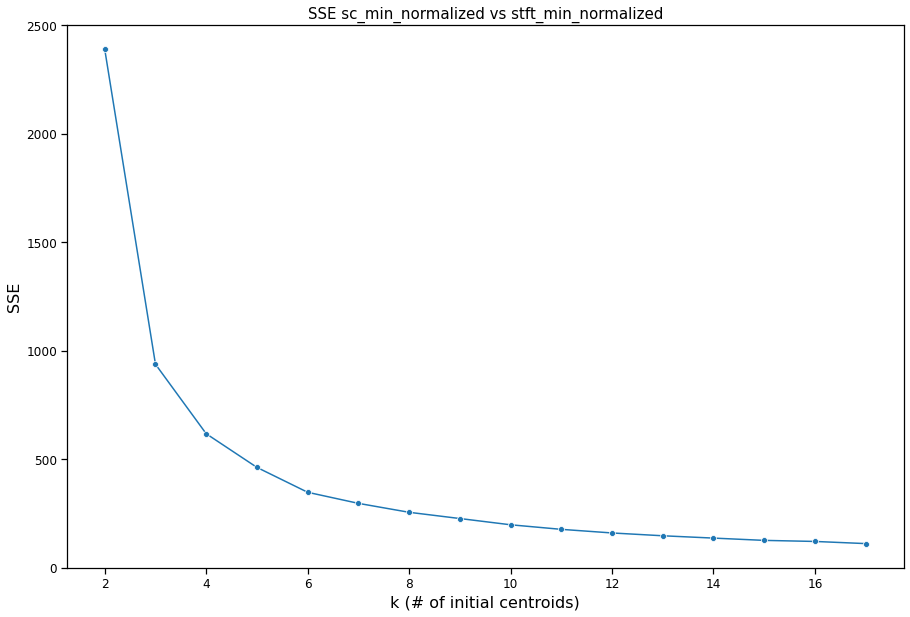

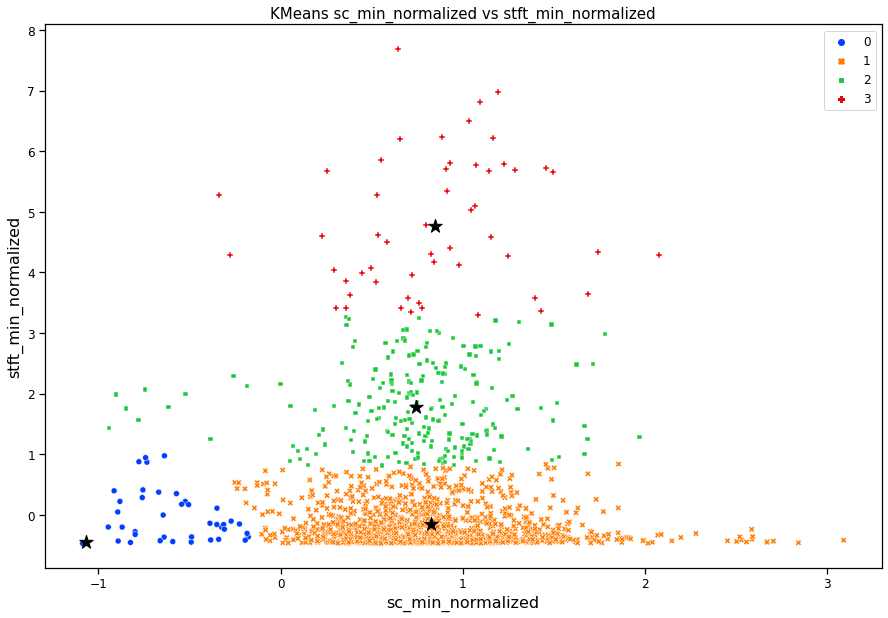

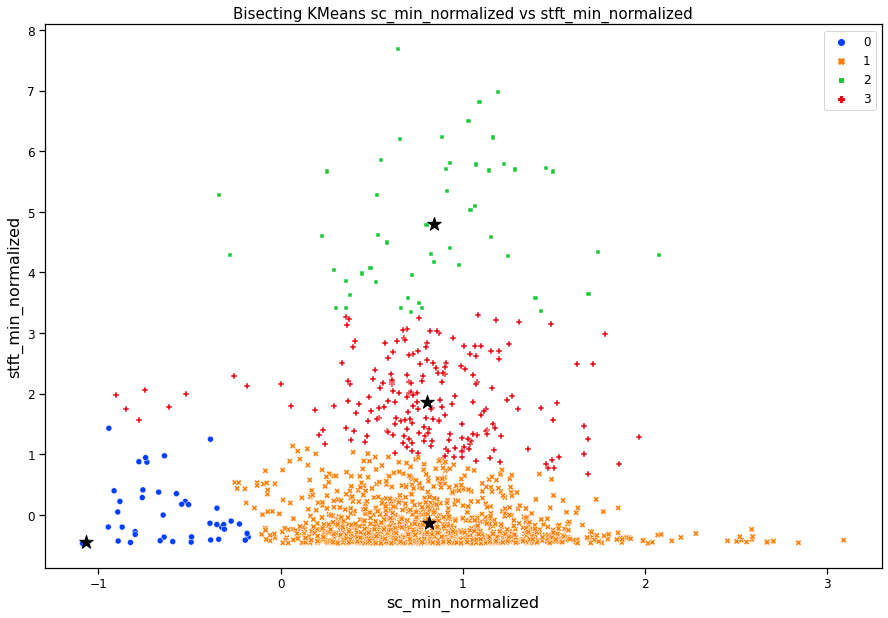

In [186]:
xvar = "sc_min_normalized"
yvar = "stft_min_normalized"
indices = [13, 16]
nclust = 4
drawSSEKMeansPlots(df_num, indices, xvar, yvar, df_num[[xvar, yvar]], nclust)

Also here the shape is irregular but four clustering seems to be enough. In Bisecting KMeans the top cluster covers more area than the KMeans's one.

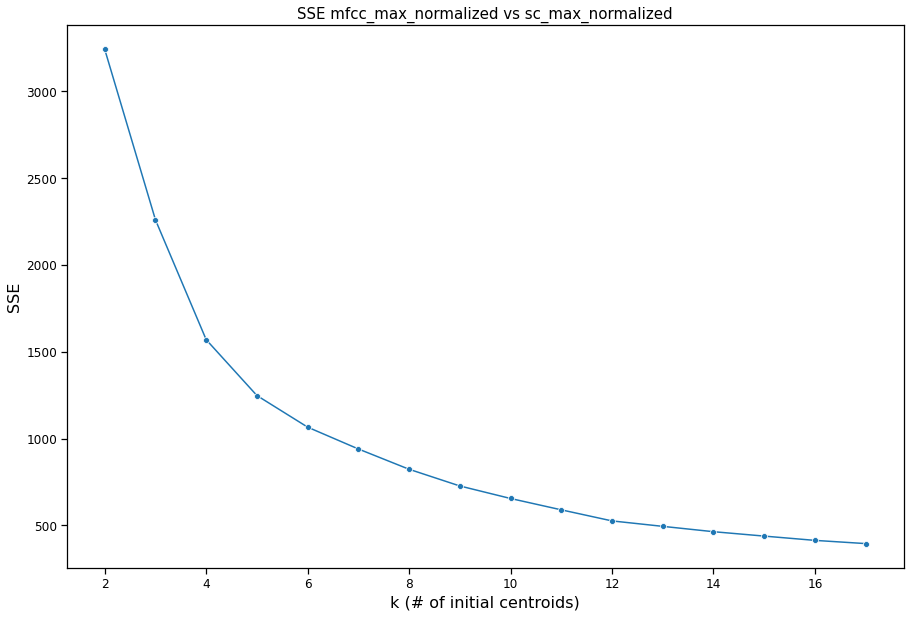

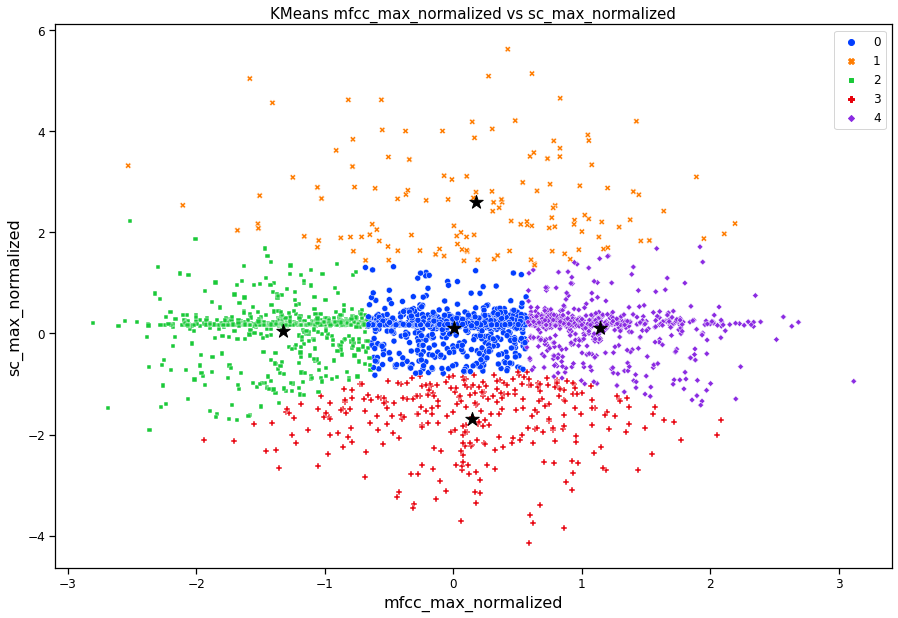

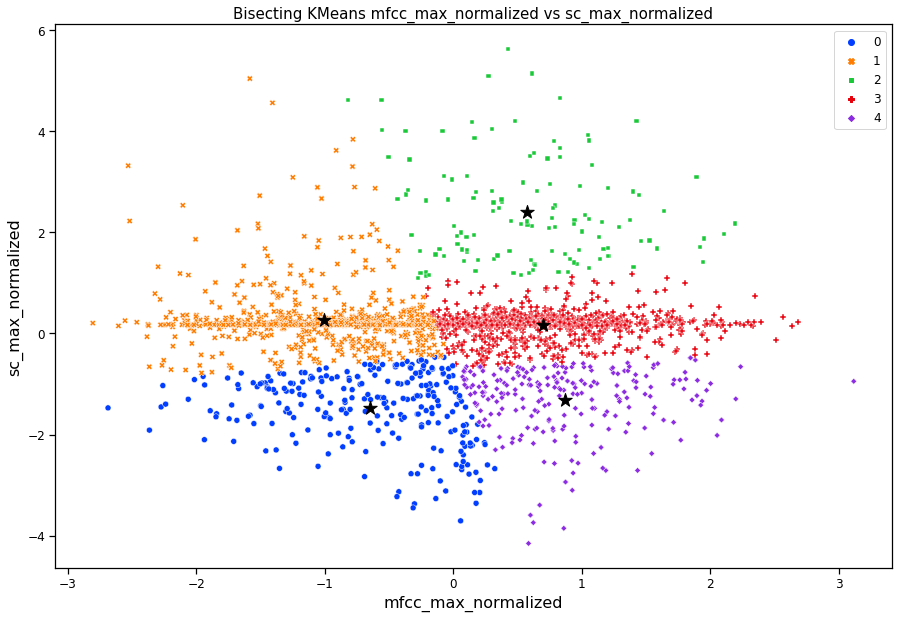

In [187]:
xvar = "mfcc_max_normalized"
yvar = "sc_max_normalized"
indices = [12, 15]
nclust = 5
drawSSEKMeansPlots(df_num, indices, xvar, yvar, df_num[[xvar, yvar]], nclust)

# Hierarchical Clustering

## Samples

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
x_label = "mfcc_mean"
y_label = "kur"

train_df = df_norm[[x_label, y_label]]
train_set = train_df.values
train_set

In [ ]:
plt.scatter(train_df[x_label], train_df[y_label])
plt.show()

In [ ]:
dist = pdist(train_set, 'euclidean')
dist = squareform(dist)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=5, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(train_set)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
sns.scatterplot(data=df_norm, x=x_label, y=y_label, hue=model.labels_, 
                style=model.labels_, palette="bright")
plt.show()

#### Choosing the number of clusters

In [ ]:
model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='complete')
model.fit(train_set)

In [ ]:
sns.scatterplot(data=df_norm, x=x_label, y=y_label, hue=model.labels_, 
                style=model.labels_, palette="bright")
plt.show()

#### Precomputed distance matrix

In [ ]:
sns.scatterplot(data=df_norm, x=x_label, y=y_label, hue=model.labels_, 
                style=model.labels_, palette="bright")
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=20, affinity='precomputed', linkage='complete')
model.fit(dist)

In [ ]:
sns.scatterplot(data=df_norm, x=x_label, y=y_label, hue=model.labels_, 
                style=model.labels_, palette="bright")
plt.show()

## Real Use

In [ ]:
#linkage {‘ward’, ‘complete’, ‘average’, ‘single’}
#se n_clusters è valorizzato, il threshold viene rimosso
#t {'dendrogram', 'scatterplot', 'both'}
def allHierarchicalClusters(datas_p, attribute = "all", t = "scatterplot", linkage="complete", threshold = 5, n_clusters = None):
    pairs = []
    datas = datas_p.copy()
    for c1 in datas:
        for c2 in datas:
            if((attribute == "all" or attribute == c1 or attribute == c2) and c1 != c2 and (not (pairs.count(c1 + " " + c2) > 0 or pairs.count(c2 + " " + c1) > 0))):
                pairs.append(c1 + " " + c2)

                x_label = c1
                y_label = c2

                train_df = datas[[x_label, y_label]]
                train_df = train_df.dropna()
                
                train_set = train_df.values

                model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, affinity='euclidean', linkage=linkage)
                if(n_clusters != None):
                    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage=linkage)
                model = model.fit(train_set)

                if(t =="dendrogram"):
                    plt.title("Hierarchical Clustering Dendrogram")
                    plot_dendrogram(model, truncate_mode="lastp")
                    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
                    plt.show()
                elif(t =="scatterplot"):
                    sns.scatterplot(data=train_df, x=x_label, y=y_label, hue=model.labels_, 
                    style=model.labels_, palette="bright")
                    plt.show()
                else:
                    sns.scatterplot(data=train_df, x=x_label, y=y_label, hue=model.labels_, 
                    style=model.labels_, palette="bright")
                    plt.show()
                    
                    plt.title("Hierarchical Clustering Dendrogram")
                    plot_dendrogram(model, truncate_mode="lastp")
                    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
                    plt.show()
    print("N: " + str(len(train_df.columns)) + " Pairs: " + str(len(pairs)))

In [ ]:
to_ignore = ["emotion_positivity", "mean"]
df_cleaned = df_norm.drop(columns=to_ignore)
#allHierarchicalClusters(df_cleaned, "all", "both")

In [ ]:
def partition_df(df, attribute, drop_categorical = True, normalize = True):
    tmp = df.copy()
    ret = {}
    to_delete = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width"]
    partitions = tmp[attribute].unique()
    for p in partitions:
        ret[p] = df[(tmp[attribute] == p)]
        if(drop_categorical):
            ret[p] = ret[p].drop(columns = to_delete)
            if(normalize):
                for v in ret[p]:
                    ret[p][v] = zscore(ret[p][v].dropna())
                
    return ret

In [ ]:
print(df.columns)

In [ ]:
attr_part = "emotional_intensity"
val = "strong"
attr = "intensity"

x = partition_df(df, attr_part, True)
df_cleaned = x[val].drop(columns=to_ignore)
df_cleaned = df_cleaned.drop(columns=correlation_drop_cols)
#allHierarchicalClusters(df_cleaned, attr)

## DBSCAN

In [ ]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width","intensity"])
df_copy

In [ ]:
df_train = df_copy[["stft_std","mfcc_std"]]

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=25, metric='euclidean')
dbscan.fit(df_train)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_train, dbscan.labels_))

In [ ]:
df_clusters = df_train.copy()
df_clusters['Labels'] = dbscan.labels_

In [ ]:
sns.scatterplot(data=df_clusters, x="stft_std", y="mfcc_std", hue=dbscan.labels_, 
                style=dbscan.labels_, palette="bright")
plt.show()

In [ ]:
d = {'key1': 'val1', 'key2': 'val2', 'key3': 'val3'}
d['key1']

In [ ]:
def DBScanTest(var1,var2):
    df_train = df_copy[[var1,var2]]
    
    dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
    dbscan.fit(df_train)

    hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

    labels_c = dict(zip(bins, hist))
#    print(labels_c)
#    val_silh = silhouette_score(df_train, dbscan.labels_)
    
    df_clusters = df_train.copy()
    df_clusters['Labels'] = dbscan.labels_
#    print(df_clusters)
    
    if len(labels_c)!= 2:
        print('silhouette', silhouette_score(df_train, dbscan.labels_))
        sns.scatterplot(data=df_clusters, x=var1, y=var2, hue=dbscan.labels_, 
        style=dbscan.labels_, palette="bright")
        plt.show()
#        return 1
    else:
        print('labels', labels_c)
#        return 0

In [ ]:
cls = df_copy.columns.tolist()
type(cls[0])

In [ ]:
columns_v = df_copy.columns.tolist()
l = len(columns_v)
for i in range(l):
    for j in range(i+1,l):
        DBScanTest(columns_v[i],columns_v[j])

In [ ]:
neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(df_train)
distances, indices = neighbors_fit.kneighbors(df_train)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### OPTICS

In [322]:
from sklearn.cluster import OPTICS

In [300]:
df_train = df_copy[["stft_std","mfcc_std"]]

In [ ]:
optics = OPTICS(eps=0.3, min_samples=10, metric='euclidean')
optics.fit(df_train)

hist, bins = np.histogram(optics.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_train, optics.labels_))

In [ ]:
df_clusters = df_train.copy()
df_clusters['Labels'] = optics.labels_

In [ ]:
sns.scatterplot(data=df_clusters, x="stft_std", y="mfcc_std", hue=optics.labels_, 
                style=optics.labels_, palette="bright")
plt.show()